In [274]:
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch.nn import MSELoss
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch_geometric.utils import add_self_loops
from sklearn.decomposition import PCA
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import seaborn as sns
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import shap

#Normal Sample Data
def load_data_from_folder(folder_path):
    """
    Load all .txt files from a folder, concatenate them into a single DataFrame.
    """
    data_list = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".txt"):
            file_path = os.path.join(folder_path, file_name)
            try:
                data = pd.read_csv(file_path, sep='\t', on_bad_lines='skip')
                data_list.append(data)
            except pd.errors.ParserError as e:
                print(f"Error parsing {file_name}: {e}")
                preview = pd.read_csv(file_path, sep='\t', nrows=10, on_bad_lines='skip')
                print(f"Preview of {file_name}:")
                print(preview)
    combined_data = pd.concat(data_list, ignore_index=True)
    return combined_data

#Expression data
expression_data_path = "/Users/teja/Documents/expression"
expression_data = load_data_from_folder(expression_data_path)

if 'Gene symbol' not in expression_data.columns or 'Normal Sample Med' not in expression_data.columns:
    raise ValueError("Required columns ('Gene symbol', 'Normal Sample Med') are missing in expression data.")

normal_expression_data = expression_data[['Gene symbol', 'Normal Sample Med']]

#List of genes
genes_of_interest = [
    "RAF1", "PRKCA", "FASLG", "RAPGEF2", "CACNG3", "RAP1A", "RASA2", "CSF1R", "RASGRP2", "MKNK2", "STMN1",
    "DUSP3", "MAP2K2", "ARAF", "ELK1", "ELK4", "ATF2", "NFKB1", "MAP2K1", "SRF", "MAPK8IP3", "SOS 1", "DUSP10", 
    "JMJD7-PLA2G4B", "PLA2G4B", "RRAS2", "RPS6KA6", "MAPT", "NF1", "GNA12", "TNFRSF1A", "PPM1B", "VRK3", 
    "BRAF", "MYC", "PYDC1", "MAPK1", "ATF4", "GRB2", "RASGRF1", "CDC25C", "DUSP1", "MAX", "PPP2CB", "RASA1", "CHUK", 
    "FOS", "MAP4K4", "MAP3K14", "PRKACA", "OSM", "IL2RB", "SOS 2", "EPOR", "PIK3R2", "CSF3", "IL2", "CCND1", "IL10RA", "IL23A", "IFNG", "IL12B", "IL4", "IL5", "IFNA7", "IL9R", 
    "LIF", "EPO", "PDGFRA", "CCND2", "PDGFRB", "IL12RB2", "CREBBP", "PIK3R3", "PIAS4", "EP300", "IL27RA", "IL7", "STAM2", "PIK3CA", "IL11", "STAT3", "EGF", "IFNAR1", "IL22RA1", 
    "OSMR", "IL9", "EGFR", "IFNA1", "IFNK", "CTF1", "IL10RB", "STAT5B", "IL15", "CSF2", "IL22RA2", "STAT6", "PRL", "IL17D", "IL12A", "IL13", "SOCS5","IL3"
]

#Remove duplicates 
normal_expression_data = normal_expression_data.drop_duplicates(subset=['Gene symbol'])

#Filter expression data
filtered_data = normal_expression_data[normal_expression_data['Gene symbol'].isin(genes_of_interest)]

missing_genes = set(genes_of_interest) - set(filtered_data['Gene symbol'])
if missing_genes:
    print(f"Warning: The following genes are missing from the normal dataset: {missing_genes}")


#Cancer data
cancer_expression_data = expression_data[['Gene symbol', 'Cancer Sample Med']]

#Remove duplicates 
cancer_expression_data = cancer_expression_data.drop_duplicates(subset=['Gene symbol'])

if 'Gene symbol' not in expression_data.columns or 'Cancer Sample Med' not in expression_data.columns:
    raise ValueError("Required columns ('Gene symbol', 'Cancer Sample Med') are missing in expression data.")

#Filter cancer data
cancer_filtered_data = cancer_expression_data[
    cancer_expression_data['Gene symbol'].isin(genes_of_interest)
]


genes_of_interest_set = set(genes_of_interest)

#Genes in both data
genes_in_normal = set(filtered_data['Gene symbol'])
genes_in_cancer = set(cancer_filtered_data['Gene symbol'])

#Missing genes 
missing_in_normal = genes_of_interest_set - genes_in_normal
missing_in_cancer = genes_of_interest_set - genes_in_cancer

print("Genes missing in the normal dataset:", missing_in_normal)
print("Genes missing in the cancer dataset:", missing_in_cancer)

#Filter Common Genes
common_genes = genes_of_interest_set - (missing_in_normal | missing_in_cancer)

filtered_data = filtered_data[filtered_data['Gene symbol'].isin(common_genes)]
cancer_filtered_data = cancer_filtered_data[cancer_filtered_data['Gene symbol'].isin(common_genes)]


filtered_data.loc[:, 'Normal Sample Med'] = pd.to_numeric(filtered_data['Normal Sample Med'], errors='coerce').fillna(0)

#Convert to tensor
expression_tensor = torch.tensor(filtered_data['Normal Sample Med'].values, dtype=torch.float).unsqueeze(1)

print("\nExpression Tensor Shape:", expression_tensor.shape)


output_path = "/Users/teja/Downloads/processed_expression_genes_data.csv"
filtered_data.to_csv(output_path, index=False)
print(f"Processed expression data for specified genes saved to {output_path}")


print("Filtered Data Columns:", filtered_data.columns)
print("First Few Rows of Filtered Data:")
print(filtered_data.head())






Genes missing in the normal dataset: {'SOS 1', 'PIK3R2', 'SOS 2', 'IL9R'}
Genes missing in the cancer dataset: {'SOS 1', 'PIK3R2', 'SOS 2', 'IL9R'}

Expression Tensor Shape: torch.Size([99, 1])
Processed expression data for specified genes saved to /Users/teja/Downloads/processed_expression_genes_data.csv
Filtered Data Columns: Index(['Gene symbol', 'Normal Sample Med'], dtype='object')
First Few Rows of Filtered Data:
     Gene symbol  Normal Sample Med
344      IL22RA1             49.366
370        STMN1            123.641
686       PIK3R3              6.976
855      IL12RB2              1.000
1119       RAP1A             53.019


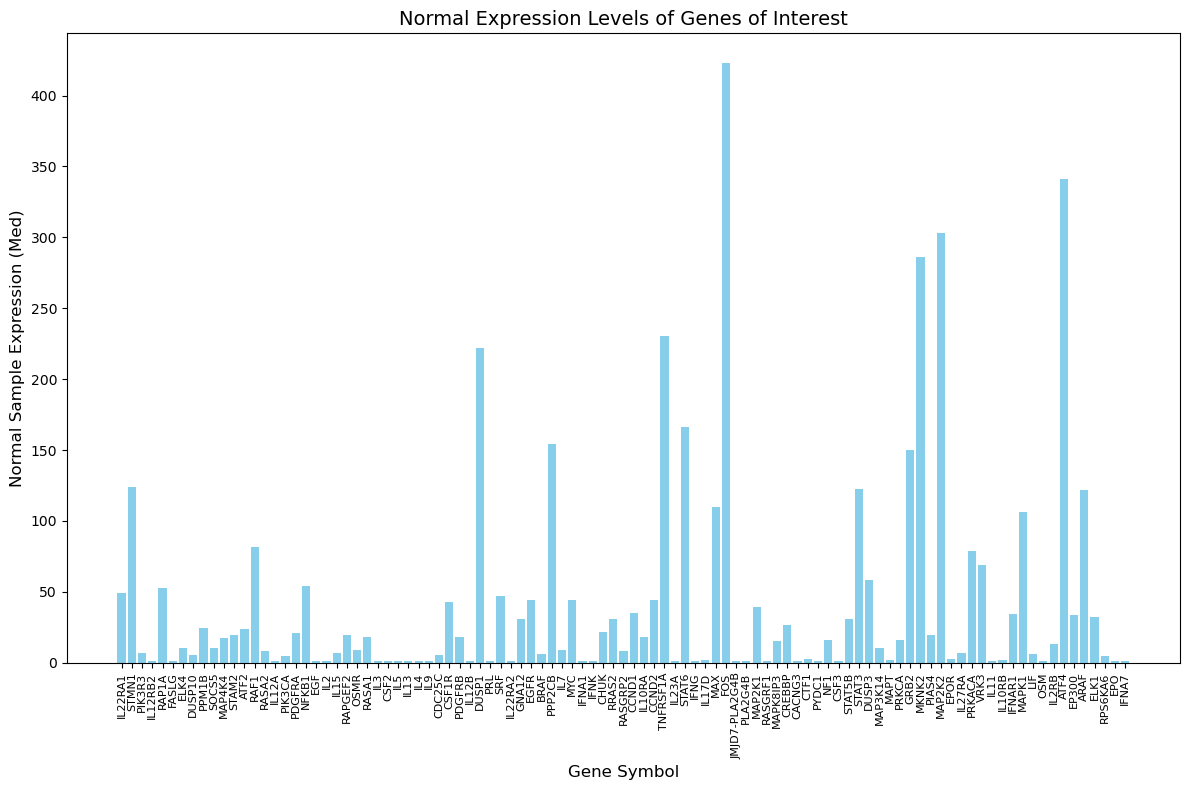

In [275]:

#Plot normal expression values
plt.figure(figsize=(12, 8))
plt.bar(filtered_data['Gene symbol'], filtered_data['Normal Sample Med'], color='skyblue')
plt.xlabel("Gene Symbol", fontsize=12)
plt.ylabel("Normal Sample Expression (Med)", fontsize=12)
plt.title("Normal Expression Levels of Genes of Interest", fontsize=14)
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

  node1   node2       node1_string_id       node2_string_id  \
0  ARAF   MAPK1  9606.ENSP00000290277  9606.ENSP00000215832   
1  ARAF   SOS 2  9606.ENSP00000290277  9606.ENSP00000216373   
2  ARAF  PPP2CB  9606.ENSP00000290277  9606.ENSP00000221138   
3  ARAF   RRAS2  9606.ENSP00000290277  9606.ENSP00000256196   
4  ARAF  MAP2K2  9606.ENSP00000290277  9606.ENSP00000262948   

   neighborhood_on_chromosome  gene_fusion  phylogenetic_cooccurrence  \
0                           0          0.0                        0.0   
1                           0          0.0                        0.0   
2                           0          0.0                        0.0   
3                           0          0.0                        0.0   
4                           0          0.0                        0.0   

   homology  coexpression  experimentally_determined_interaction  \
0     0.592         0.094                                  0.110   
1     0.000         0.064                     

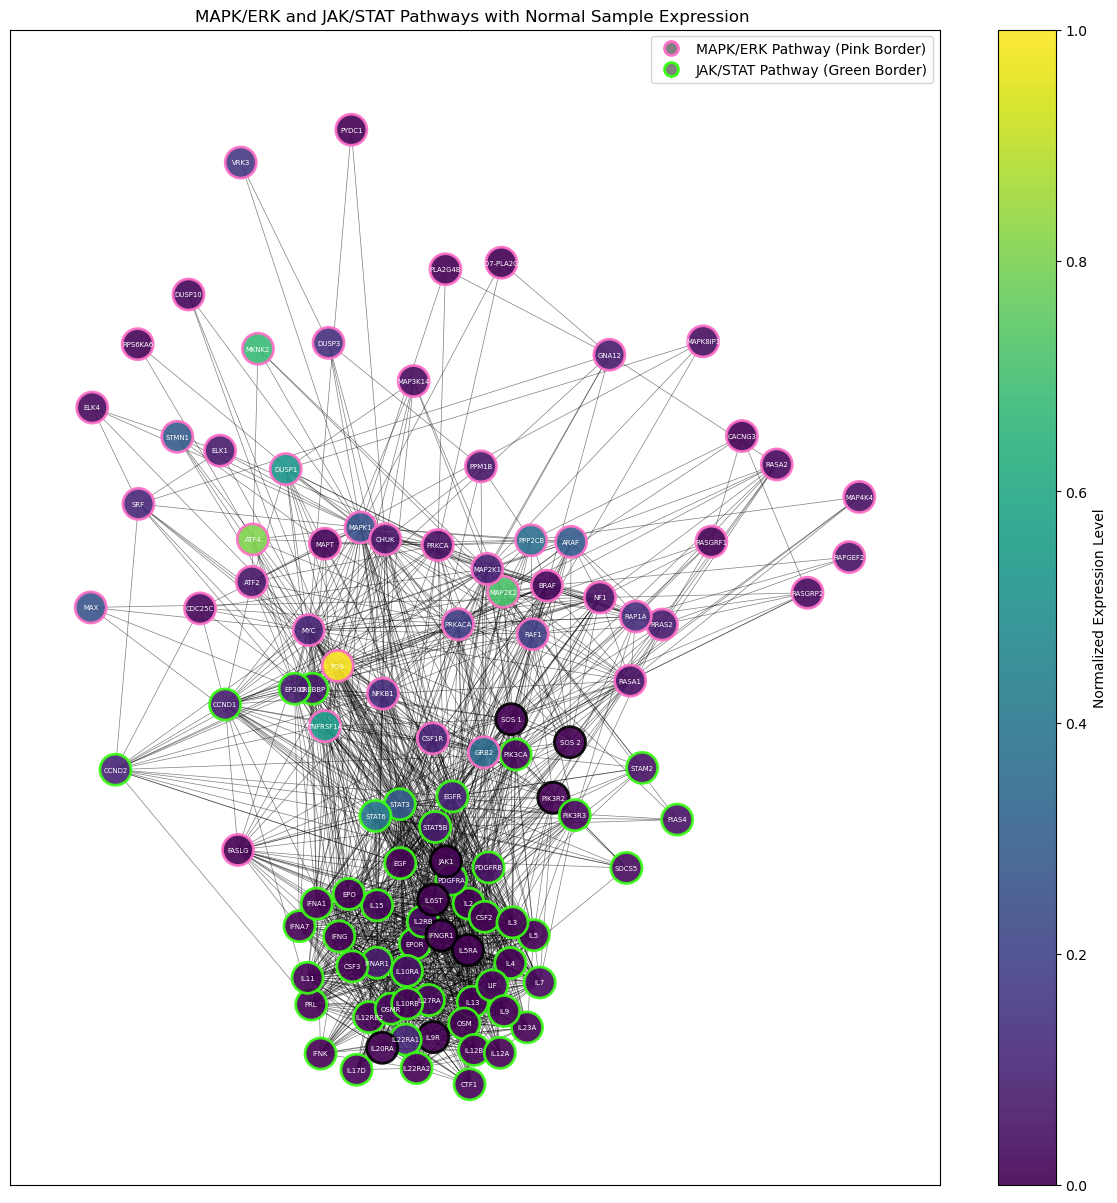

Graph Nodes with Features and Expression Data:
     Node  Expression   Pathway  DegreeCentrality  BetweennessCentrality  \
0    ARAF     121.850  MAPK/ERK          0.158879               0.000000   
1   MAPK1     106.494  MAPK/ERK          0.448598               0.010075   
2   SOS 2       0.000     Other          0.205607               0.008641   
3  PPP2CB     153.954  MAPK/ERK          0.140187               0.000000   
4   RRAS2      31.104  MAPK/ERK          0.158879               0.000000   

   WeightedDegree  
0          4.9515  
1         13.3045  
2          4.1278  
3          3.5019  
4          5.6390  


In [276]:
#Pathway data -- string interactions
column_names = [
    "node1", "node2", "node1_string_id", "node2_string_id",
    "neighborhood_on_chromosome", "gene_fusion", "phylogenetic_cooccurrence",
    "homology", "coexpression", "experimentally_determined_interaction",
    "database_annotated", "automated_textmining", "combined_score"
]
pathway_data = pd.read_csv('/Users/teja/Documents/string_interactions2_1211.csv', header=1, names=column_names)

print(pathway_data.head())

#Normal sample data
expression_data = pd.read_csv('/Users/teja/Downloads/processed_expression_genes_data.csv')

#Map gene expression to nodes
expression_mapping = dict(zip(expression_data['Gene symbol'], expression_data['Normal Sample Med']))

#MAPK/ERK and JAK/STAT genes
mapk_genes = [
    "RAF1", "PRKCA", "FASLG", "RAPGEF2", "CACNG3", "RAP1A", "RASA2", "CSF1R", "RASGRP2", "MKNK2", "STMN1",
    "DUSP3", "MAP2K2", "ARAF", "ELK1", "ELK4", "ATF2", "NFKB1", "MAP2K1", "SRF", "MAPK8IP3", "SOS 1", "DUSP10", 
    "JMJD7-PLA2G4B", "PLA2G4B", "RRAS2", "RPS6KA6", "MAPT", "NF1", "GNA12", "TNFRSF1A", "PPM1B", 
    "BRAF", "MYC", "PYDC1", "MAPK1", "ATF4", "GRB2", "RASGRF1", "CDC25C", "DUSP1", "MAX", "PPP2CB", "RASA1", "CHUK", 
    "FOS", "MAP4K4", "MAP3K14", "PRKACA", "VRK3"
]
jak_stat_genes = [
    "OSM", "IL2RB", "SOS 2", "EPOR", "CSF3", "IL2", "CCND1", "IL10RA", "IL23A", "IFNG", "IL12B", "IL4", "IL5", "IFNA7", 
    "LIF", "EPO", "PDGFRA", "CCND2", "PDGFRB", "IL12RB2", "CREBBP", "PIK3R3", "PIAS4", "EP300", "IL27RA", "IL7", "STAM2", 
    "PIK3CA", "IL11", "STAT3", "EGF", "IFNAR1", "IL22RA1", "OSMR", "IL9", "EGFR", "IFNA1", "IFNK", "CTF1", "IL10RB", 
    "STAT5B", "IL15", "CSF2", "IL22RA2", "STAT6", "PRL", "IL17D", "IL12A", "IL13", "SOCS5","IL3"
]

#Combined edge weights 
pathway_data['combined_edge_weight'] = (
     pathway_data['experimentally_determined_interaction'] * 0.4 +
     pathway_data['coexpression'] * 0.3 +
     pathway_data['database_annotated'] * 0.3
 )

edges = pathway_data[['node1', 'node2', 'combined_edge_weight']].values.tolist()

#Network graph
G = nx.Graph()
G.add_weighted_edges_from(edges)


for node in G.nodes:
    G.nodes[node]['expression'] = expression_mapping.get(node, 0)  
    G.nodes[node]['pathway'] = 'MAPK/ERK' if node in mapk_genes else 'JAK/STAT' if node in jak_stat_genes else 'Other'

#Graph features
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
weighted_degree = {
    node: sum(data['weight'] for _, _, data in G.edges(node, data=True)) for node in G.nodes
}

#Normalize
expression_values = [G.nodes[node]['expression'] for node in G.nodes]
max_expression = max(expression_values) if expression_values else 1
normalized_expression = [value / max_expression for value in expression_values]


#Plot
node_colors = []
node_border_colors = []

for node in G.nodes:
    if node in mapk_genes:
        node_border_colors.append('#FF6EC7') 
    elif node in jak_stat_genes:
        node_border_colors.append('#39FF14')  
    else:
        node_border_colors.append('black') 


plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, seed=42)  
nodes = nx.draw_networkx_nodes(
    G, 
    pos, 
    node_size=500, 
    node_color=normalized_expression, 
    edgecolors=node_border_colors, 
    cmap=plt.cm.viridis, 
    alpha=0.9, 
    linewidths=2 
)
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=5, font_color='white')
cbar = plt.colorbar(nodes)
cbar.set_label('Normalized Expression Level')
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='MAPK/ERK Pathway (Pink Border)',
           markerfacecolor='gray', markeredgecolor='#FF6EC7', markersize=10, markeredgewidth=2),
    Line2D([0], [0], marker='o', color='w', label='JAK/STAT Pathway (Green Border)',
           markerfacecolor='gray', markeredgecolor='#39FF14', markersize=10, markeredgewidth=2)
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=10, frameon=True)

plt.title("MAPK/ERK and JAK/STAT Pathways with Normal Sample Expression ")
plt.show()

output_data = []
for node in G.nodes(data=True):
    output_data.append({
        'Node': node[0],
        'Expression': node[1].get('expression', 0),
        'Pathway': node[1].get('pathway', 'Other'),
        'DegreeCentrality': degree_centrality.get(node[0], 0),
        'BetweennessCentrality': betweenness_centrality.get(node[0], 0),
        'WeightedDegree': weighted_degree.get(node[0], 0),
    })

network_graph_df = pd.DataFrame(output_data)
network_graph_df.to_csv('pathway_network_with_expression_and_features.csv', index=False)

print("Graph Nodes with Features and Expression Data:")
print(network_graph_df.head())


In [277]:
#Map expression to nodes
expression_mapping = dict(zip(expression_data['Gene symbol'], expression_data['Normal Sample Med']))


nodes = list(set([edge[0] for edge in edges] + [edge[1] for edge in edges]))
node_to_index = {node: i for i, node in enumerate(nodes)}

#Edge index
edge_index = torch.tensor(
    [(node_to_index[edge[0]], node_to_index[edge[1]]) for edge in edges if edge[0] in node_to_index and edge[1] in node_to_index],
    dtype=torch.long
).t().contiguous()

#Edge weights
edge_weights = torch.tensor(
    [edge[2] for edge in edges if edge[0] in node_to_index and edge[1] in node_to_index],
    dtype=torch.float
)

#Network graph 
G_nx = nx.Graph()
G_nx.add_weighted_edges_from(edges)

#network features
degree_centrality = nx.degree_centrality(G_nx)
closeness_centrality = nx.closeness_centrality(G_nx)
betweenness_centrality = nx.betweenness_centrality(G_nx, weight="weight")
clustering_coefficient = nx.clustering(G_nx)

#network features to nodes
network_features = {
    node: [
        degree_centrality.get(node, 0),
        closeness_centrality.get(node, 0),
        betweenness_centrality.get(node, 0),
        clustering_coefficient.get(node, 0),
    ]
    for node in G_nx.nodes()
}

#Normalize 
network_features_tensor = torch.tensor(
    [network_features.get(node, [0, 0, 0, 0]) for node in nodes],
    dtype=torch.float
)
feature_scaler = MinMaxScaler()
normalized_network_features = feature_scaler.fit_transform(network_features_tensor.numpy())
network_features_tensor = torch.tensor(normalized_network_features, dtype=torch.float)


#Map expression to nodes 
expression_tensor = torch.tensor(
    [expression_mapping.get(node, 0) for node in nodes],
    dtype=torch.float
).unsqueeze(1)  # Add a dimension for concatenation
expression_scaler = MinMaxScaler()
normalized_expression = expression_scaler.fit_transform(expression_tensor.numpy())
expression_tensor = torch.tensor(normalized_expression, dtype=torch.float)

enhanced_features = torch.cat([expression_tensor, network_features_tensor], dim=1)

#Align with genes
filtered_nodes = [node for node in nodes if node in genes_of_interest]
filtered_node_to_index = {node: i for i, node in enumerate(filtered_nodes)}

#filter
filtered_edge_index = torch.tensor(
    [
        (filtered_node_to_index[edge[0]], filtered_node_to_index[edge[1]])
        for edge in edges
        if edge[0] in filtered_node_to_index and edge[1] in filtered_node_to_index
    ],
    dtype=torch.long
).t().contiguous()


filtered_edge_weights = torch.tensor(
    [
        edge[2] for edge in edges
        if edge[0] in filtered_node_to_index and edge[1] in filtered_node_to_index
    ],
    dtype=torch.float
)

filtered_indices = [node_to_index[node] for node in filtered_nodes]
filtered_features = enhanced_features[filtered_indices]


filtered_labels = torch.tensor(
    [expression_mapping.get(node, 0) for node in filtered_nodes],
    dtype=torch.float
)
label_scaler = MinMaxScaler()
normalized_labels = label_scaler.fit_transform(filtered_labels.numpy().reshape(-1, 1))
filtered_labels = torch.tensor(normalized_labels.flatten(), dtype=torch.float)

#data object
data = Data(x=filtered_features, edge_index=filtered_edge_index, edge_attr=filtered_edge_weights)

if data.x.shape[0] != len(filtered_labels):
    raise ValueError("Mismatch between node features and labels!")

data.y = filtered_labels

#Split data -- training and validation
num_nodes = data.x.shape[0]
train_idx, val_idx = train_test_split(range(num_nodes), test_size=0.2, random_state=42)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
val_mask[val_idx] = True

data.train_mask = train_mask
data.val_mask = val_mask

#GAT 
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4):
        super(GAT, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, edge_dim=1) 
        self.gat2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, edge_dim=1)
        self.gat3 = GATConv(hidden_channels * heads, out_channels, heads=1, edge_dim=1)
        self.fc = torch.nn.Linear(out_channels, 1)

    def forward(self, x, edge_index, edge_attr):
       
        x = self.gat1(x, edge_index, edge_attr)
        x = torch.nn.functional.elu(x)
        x = self.gat2(x, edge_index, edge_attr)
        x = torch.nn.functional.elu(x)
        x = self.gat3(x, edge_index, edge_attr)
        x = torch.nn.functional.elu(x)
        
        
        embeddings = x.clone()

      
        predictions = self.fc(x)
        return embeddings, predictions


model = GAT(in_channels=data.x.shape[1], hidden_channels=16, out_channels=8, heads=4)

#Training
criterion = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  

def train():
    model.train()
    optimizer.zero_grad()
    embeddings, output = model(data.x, data.edge_index, data.edge_attr)  
    output = output.squeeze()
    loss = criterion(output[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def validate():
    model.eval()
    with torch.no_grad():
        embeddings, output = model(data.x, data.edge_index, data.edge_attr)  
        output = output.squeeze()
        loss = criterion(output[data.val_mask], data.y[data.val_mask])
    return loss.item()


epochs = 500
for epoch in range(epochs):
    train_loss = train()
    val_loss = validate()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


model.eval()
with torch.no_grad():
    final_embeddings, final_predictions = model(data.x, data.edge_index, data.edge_attr)


final_predictions = final_predictions.detach().numpy().flatten()
final_embeddings = final_embeddings.detach().numpy()

#Pathway activity scores
cluster_composition = pd.DataFrame({'Gene': filtered_nodes})
cluster_composition['GAT_Embedding'] = list(final_embeddings)  
cluster_composition['Predicted Expression'] = final_predictions


pathway_activity_scores_df = cluster_composition
pathway_activity_scores_df.to_csv('/Users/teja/Downloads/pathway_activity_scores_df.csv', index=False)
print("\nAll Normal Pathway Activity Scores:")
print(pathway_activity_scores_df.to_string(index=False))


#Evaluate GAT
total_indices = list(range(data.x.shape[0]))

#splitting data --train, validate, test
train_idx, temp_idx = train_test_split(total_indices, test_size=0.4, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

train_mask = torch.zeros(data.x.shape[0], dtype=torch.bool)
val_mask = torch.zeros(data.x.shape[0], dtype=torch.bool)
test_mask = torch.zeros(data.x.shape[0], dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True


print(f"Training Indices: {len(train_idx)}")
print(f"Validation Indices: {len(val_idx)}")
print(f"Test Indices: {len(test_idx)}")

#Evaluate
model.eval()
with torch.no_grad():
    embeddings, predictions = model(data.x, data.edge_index, data.edge_attr)  
    predictions = predictions.squeeze()  
    test_predictions = predictions[test_mask]  
    test_labels = data.y[test_mask]  
    test_loss = torch.nn.functional.mse_loss(test_predictions, test_labels)
    print(f"Test Loss: {test_loss.item()}")


print("Test Predictions:")
print(test_predictions.numpy())
print("True Labels:")
print(test_labels.numpy())

#Evaluation metrics
mse = mean_squared_error(test_labels.numpy(), test_predictions.numpy())
mae = mean_absolute_error(test_labels.numpy(), test_predictions.numpy())
r2 = r2_score(test_labels.numpy(), test_predictions.numpy())


print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")


final_embeddings = embeddings.detach().numpy()  
torch.save(model.state_dict(), '/Users/teja/Documents/mapkjak_gat_model.pth')
np.save('/Users/teja/Documents/mapkjak_gat_embeddings.npy', final_embeddings)  
print("Model and embeddings saved to /Users/teja/Documents/")


Epoch 0, Train Loss: 0.0609, Validation Loss: 0.0359
Epoch 10, Train Loss: 0.0361, Validation Loss: 0.0271
Epoch 20, Train Loss: 0.0352, Validation Loss: 0.0260
Epoch 30, Train Loss: 0.0346, Validation Loss: 0.0257
Epoch 40, Train Loss: 0.0342, Validation Loss: 0.0248
Epoch 50, Train Loss: 0.0338, Validation Loss: 0.0242
Epoch 60, Train Loss: 0.0334, Validation Loss: 0.0235
Epoch 70, Train Loss: 0.0331, Validation Loss: 0.0226
Epoch 80, Train Loss: 0.0328, Validation Loss: 0.0219
Epoch 90, Train Loss: 0.0325, Validation Loss: 0.0211
Epoch 100, Train Loss: 0.0323, Validation Loss: 0.0203
Epoch 110, Train Loss: 0.0321, Validation Loss: 0.0196
Epoch 120, Train Loss: 0.0319, Validation Loss: 0.0190
Epoch 130, Train Loss: 0.0318, Validation Loss: 0.0186
Epoch 140, Train Loss: 0.0318, Validation Loss: 0.0182
Epoch 150, Train Loss: 0.0317, Validation Loss: 0.0180
Epoch 160, Train Loss: 0.0316, Validation Loss: 0.0178
Epoch 170, Train Loss: 0.0315, Validation Loss: 0.0176
Epoch 180, Train Loss

In [278]:
expression_data_path = "/Users/teja/Documents/expression"
expression_data = load_data_from_folder(expression_data_path)


genes_of_interest = [
    "RAF1", "PRKCA", "FASLG", "RAPGEF2", "CACNG3", "RAP1A", "RASA2", "CSF1R", "RASGRP2", "MKNK2", "STMN1",
    "DUSP3", "MAP2K2", "ARAF", "ELK1", "ELK4", "ATF2", "NFKB1", "MAP2K1", "SRF", "MAPK8IP3", "SOS1", "DUSP10",
    "JMJD7-PLA2G4B", "PLA2G4B", "RRAS2", "RPS6KA6", "MAPT", "NF1", "GNA12", "TNFRSF1A", "PPM1B", "VRK3",
    "BRAF", "MYC", "PYDC1", "MAPK1", "ATF4", "GRB2", "RASGRF1", "CDC25C", "DUSP1", "MAX", "PPP2CB", "RASA1", "CHUK",
    "FOS", "MAP4K4", "MAP3K14", "PRKACA", "OSM", "IL2RB", "SOS2", "EPOR", "PIK3R2", "CSF3", "IL2", "CCND1", "IL10RA",
    "IL23A", "IFNG", "IL12B", "IL4", "IL5", "IFNA7", "IL9R", "LIF", "EPO", "PDGFRA", "CCND2", "PDGFRB", "IL12RB2",
    "CREBBP", "PIK3R3", "PIAS4", "EP300", "IL27RA", "IL7", "STAM2", "PIK3CA", "IL11", "STAT3", "EGF", "IFNAR1",
    "IL22RA1", "OSMR", "IL9", "EGFR", "IFNA1", "IFNK", "CTF1", "IL10RB", "STAT5B", "IL15", "CSF2", "IL22RA2",
    "STAT6", "PRL", "IL17D", "IL12A", "IL13", "SOCS5", "IL3"
]

#Filter Cancer Data 
if 'Gene symbol' not in expression_data.columns or 'Cancer Sample Med' not in expression_data.columns:
    raise ValueError("Required columns ('Gene symbol', 'Cancer Sample Med') are missing in expression data.")

cancer_expression_data = expression_data[['Gene symbol', 'Cancer Sample Med']].drop_duplicates(subset=['Gene symbol'])
cancer_filtered_data = cancer_expression_data[cancer_expression_data['Gene symbol'].isin(genes_of_interest)]

#Map Cancer Expression
cancer_expression_mapping = dict(zip(cancer_filtered_data['Gene symbol'], cancer_filtered_data['Cancer Sample Med']))
cancer_expression_tensor = torch.tensor(
    [cancer_expression_mapping.get(gene, 0) for gene in genes_of_interest],
    dtype=torch.float
).unsqueeze(1)

#Normalize
expression_scaler = MinMaxScaler()
normalized_cancer_expression = expression_scaler.fit_transform(cancer_expression_tensor.numpy())
cancer_expression_tensor = torch.tensor(normalized_cancer_expression, dtype=torch.float)

#Align network
filtered_network_features = []
for gene in genes_of_interest:
    if gene in nodes:
        filtered_network_features.append(network_features_tensor[nodes.index(gene)])
    else:
        filtered_network_features.append(torch.zeros(network_features_tensor.shape[1]))

filtered_network_features_tensor = torch.stack(filtered_network_features)

assert cancer_expression_tensor.shape[0] == filtered_network_features_tensor.shape[0], (
    f"Expression tensor size {cancer_expression_tensor.shape[0]} and network features size "
    f"{filtered_network_features_tensor.shape[0]} do not match."
)

#Combine cancer  and network features
cancer_enhanced_features = torch.cat([cancer_expression_tensor, filtered_network_features_tensor], dim=1)

cancer_data_x = cancer_enhanced_features
cancer_labels = cancer_expression_tensor.squeeze()  

#Edge_index 
if edge_index.ndim != 2 or edge_index.shape[0] != 2:
    print(f"Initial edge_index shape: {edge_index.shape}")
    edge_index = edge_index.view(2, -1)  
    print(f"Fixed edge_index shape: {edge_index.shape}")

invalid_edges = (edge_index >= cancer_data_x.shape[0]).any(dim=0)
if invalid_edges.any():
    print("Found invalid edges in edge_index. Removing them.")
    edge_index = edge_index[:, ~invalid_edges]
    if edge_weights is not None:
        edge_weights = edge_weights[~invalid_edges]

edge_index, edge_attr = add_self_loops(edge_index, edge_attr=edge_weights, fill_value=0.0, num_nodes=cancer_data_x.shape[0])

if edge_attr.size(0) < edge_index.size(1):
    additional_attr = torch.zeros(edge_index.size(1) - edge_attr.size(0), dtype=edge_attr.dtype)
    edge_attr = torch.cat([edge_attr, additional_attr], dim=0)

if edge_attr.size(0) != edge_index.size(1):
    edge_attr = edge_attr[:edge_index.size(1)]  

#data object
cancer_data = Data(x=cancer_data_x, edge_index=edge_index, edge_attr=edge_attr)
cancer_data.y = cancer_labels

assert cancer_data_x.shape[0] == len(genes_of_interest), "Mismatch in gene feature alignment."
assert len(cancer_labels) == len(genes_of_interest), "Mismatch in gene label alignment."

#Load pre-trained normal GAT + load for cancer data
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4):
        super(GAT, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, edge_dim=1)
        self.gat2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, edge_dim=1)
        self.gat3 = GATConv(hidden_channels * heads, out_channels, heads=1, edge_dim=1)
        self.fc = torch.nn.Linear(out_channels, 1)

    def forward(self, x, edge_index, edge_attr):
        x = self.gat1(x, edge_index, edge_attr)
        x = torch.nn.functional.elu(x)
        x = self.gat2(x, edge_index, edge_attr)
        x = torch.nn.functional.elu(x)
        x = self.gat3(x, edge_index, edge_attr)
        embeddings = x.clone()
        predictions = self.fc(x)
        return embeddings, predictions

pretrained_model_path = '/Users/teja/Documents/mapkjak_gat_model.pth'
model = GAT(in_channels=cancer_data_x.shape[1], hidden_channels=16, out_channels=8, heads=4)
model.load_state_dict(torch.load(pretrained_model_path))
model.eval()

with torch.no_grad():
    embeddings, predictions = model(cancer_data.x, cancer_data.edge_index, cancer_data.edge_attr)
    predictions = predictions.squeeze()


cancer_results_df = pd.DataFrame({
    "Gene": genes_of_interest,
    "Cancer GAT Embeddings": list(embeddings.numpy()),
    "Cancer Predictions": predictions.numpy()
})


output_path = '/Users/teja/Downloads/cancer_gat_results.csv'
cancer_results_df.to_csv(output_path, index=False)
print(f"Cancer GAT results saved to {output_path}")

#Pathway Activity Scores
cancer_activity_scores = []

expression_scaler = MinMaxScaler()
predictions_scaled = expression_scaler.fit_transform(predictions.numpy().reshape(-1, 1)).squeeze()

for idx, gene in enumerate(genes_of_interest):
    expression_value = cancer_labels[idx].item()
    prediction_value = predictions_scaled[idx]  
    activity_score = 0.5 * expression_value + 0.5 * prediction_value
    cancer_activity_scores.append({
        "Gene": gene,
        "GAT_Embedding": embeddings[idx].numpy(),
        "Activity_Score": activity_score
    })


cancer_activity_scores_df = pd.DataFrame(cancer_activity_scores)


print("Pathway Activity Scores:")
print(cancer_activity_scores_df[["Gene", "Activity_Score"]])


activity_output_path = '/Users/teja/Downloads/cancer_pathway_activity_scores.csv'
cancer_activity_scores_df.to_csv(activity_output_path, index=False)
print(f"Cancer Pathway Activity Scores saved to {activity_output_path}")

print(f"Original feature dimensions: {data.x.shape}")

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=2):
        super(GAT, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads)  
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1)
        self.fc = torch.nn.Linear(out_channels, 1) 
        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = torch.nn.functional.elu(x) 
        x = self.dropout(x)
        x = self.gat2(x, edge_index)
        x = torch.nn.functional.elu(x)
        x = self.dropout(x)
        x = self.fc(x)  
        return x

input_dim = data.x.shape[1]  
model = GAT(in_channels=input_dim, hidden_channels=16, out_channels=8, heads=4) 

#Training 
criterion = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=10, verbose=True)


def train():
    model.train()
    optimizer.zero_grad()
    output = model(data.x, data.edge_index).squeeze()
    loss = criterion(output[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def validate():
    model.eval()
    with torch.no_grad():
        output = model(data.x, data.edge_index).squeeze()
        loss = criterion(output[data.val_mask], data.y[data.val_mask])
    return loss.item()


epochs = 500
for epoch in range(epochs):
    train_loss = train()
    val_loss = validate()
    scheduler.step(val_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

#Evaluate 
model.eval()
with torch.no_grad():
    predictions = model(data.x, data.edge_index).squeeze()

val_predictions = predictions[data.val_mask]
val_labels = data.y[data.val_mask]

print("\nValidation Predictions:")
print(val_predictions)
print("\nValidation True Labels:")
print(val_labels)

#Evaluation metrics
predictions_array = val_predictions.numpy()
labels_array = val_labels.numpy()

mse = mean_squared_error(labels_array, predictions_array)
mae = mean_absolute_error(labels_array, predictions_array)
r2 = r2_score(labels_array, predictions_array)

print("\nModel Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Found invalid edges in edge_index. Removing them.
Cancer GAT results saved to /Users/teja/Downloads/cancer_gat_results.csv
Pathway Activity Scores:
        Gene  Activity_Score
0       RAF1        0.350577
1      PRKCA        0.262000
2      FASLG        0.154987
3    RAPGEF2        0.425083
4     CACNG3        0.422256
..       ...             ...
98     IL17D        0.105997
99     IL12A        0.215725
100     IL13        0.177798
101    SOCS5        0.376396
102      IL3        0.378651

[103 rows x 2 columns]
Cancer Pathway Activity Scores saved to /Users/teja/Downloads/cancer_pathway_activity_scores.csv
Original feature dimensions: torch.Size([101, 5])
Epoch 0, Train Loss: 0.0389, Validation Loss: 0.0236
Epoch 10, Train Loss: 0.0359, Validation Loss: 0.0230
Epoch 20, Train Loss: 0.0320, Validation Loss: 0.0222
Epoch 30, Train Loss: 0.0334, Validation Loss: 0.0214


/var/folders/vw/8wh4b3l534q3sd8fkct0l0xr0000gn/T/ipykernel_59127/2794077118.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrained

Epoch 40, Train Loss: 0.0350, Validation Loss: 0.0209
Epoch 50, Train Loss: 0.0333, Validation Loss: 0.0203
Epoch 60, Train Loss: 0.0332, Validation Loss: 0.0198
Epoch 70, Train Loss: 0.0338, Validation Loss: 0.0192
Epoch 80, Train Loss: 0.0322, Validation Loss: 0.0187
Epoch 90, Train Loss: 0.0326, Validation Loss: 0.0185
Epoch 100, Train Loss: 0.0305, Validation Loss: 0.0177
Epoch 110, Train Loss: 0.0307, Validation Loss: 0.0173
Epoch 120, Train Loss: 0.0317, Validation Loss: 0.0170
Epoch 130, Train Loss: 0.0315, Validation Loss: 0.0168
Epoch 140, Train Loss: 0.0293, Validation Loss: 0.0165
Epoch 150, Train Loss: 0.0310, Validation Loss: 0.0169
Epoch 160, Train Loss: 0.0305, Validation Loss: 0.0159
Epoch 170, Train Loss: 0.0305, Validation Loss: 0.0156
Epoch 180, Train Loss: 0.0327, Validation Loss: 0.0163
Epoch 190, Train Loss: 0.0312, Validation Loss: 0.0153
Epoch 200, Train Loss: 0.0303, Validation Loss: 0.0152
Epoch 210, Train Loss: 0.0301, Validation Loss: 0.0153
Epoch 220, Train

In [279]:
#Mutation Data
def load_mutation_data(folder_path):
    mutation_columns = [
        "Sample_ID", "Gene_Symbol", "Chromosome", "Position", "Reference", "Variant",
        "cDNA_Change", "Protein_Change", "Mutation_Type", "DNA", "RNA"
    ]
    data_list = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".txt"):
            file_path = os.path.join(folder_path, file_name)
            data = pd.read_csv(file_path, sep='\t', header=None, names=mutation_columns, on_bad_lines="skip")
            data_list.append(data)
    combined_data = pd.concat(data_list, ignore_index=True)
    return combined_data

mutation_folder_path = "/Users/teja/Documents/mutation"  
mutation_data = load_mutation_data(mutation_folder_path)

#Filter 
Mapk_genes = [
    "RAF1", "PRKCA", "FASLG", "RAPGEF2", "CACNG3", "RAP1A", "RASA2", "CSF1R", "RASGRP2", "MKNK2", "STMN1",
    "DUSP3", "MAP2K2", "ARAF", "ELK1", "ELK4", "ATF2", "NFKB1", "MAP2K1", "SRF", "MAPK8IP3", "DUSP10", 
    "JMJD7-PLA2G4B", "PLA2G4B", "RRAS2", "RPS6KA6", "MAPT", "NF1", "GNA12", "TNFRSF1A", "PPM1B", "VRK3", 
    "BRAF", "MYC", "PYDC1", "MAPK1", "ATF4", "GRB2", "RASGRF1", "CDC25C", "DUSP1", "MAX", "PPP2CB", "RASA1", "CHUK", 
    "FOS", "MAP4K4", "MAP3K14", "PRKACA"
]

filtered_mutation_data = mutation_data[
    mutation_data['Gene_Symbol'].isin(Mapk_genes) &
    mutation_data['Mutation_Type'].isin(["Frame_Shift_Del", "Missense_Mutation", "Nonsense_Mutation"])
]

#One-Hot Encoder
encoder = OneHotEncoder(sparse_output=False)
encoded_mutations = encoder.fit_transform(filtered_mutation_data[['Mutation_Type']])

#Aggregate features 
mutation_features = pd.DataFrame(
    encoded_mutations,
    columns=encoder.get_feature_names_out(['Mutation_Type']),
    index=filtered_mutation_data['Gene_Symbol']
).groupby('Gene_Symbol').sum()


extra_genes = set(mutation_features.index) - set(Mapk_genes)
missing_genes = set(Mapk_genes) - set(mutation_features.index)

print(f"Extra genes in mutation features: {extra_genes}")
print(f"Missing genes in mutation features: {missing_genes}")


aligned_mutation_features = mutation_features.reindex(Mapk_genes).fillna(0)


print(f"Aligned mutation features shape: {aligned_mutation_features.shape}")

#Tensor
mutation_tensor = torch.tensor(aligned_mutation_features.values, dtype=torch.float)

#Normalize
mutation_scaler = MinMaxScaler()
normalized_mutation_scores = mutation_scaler.fit_transform(mutation_tensor.numpy())
mutation_tensor = torch.tensor(normalized_mutation_scores, dtype=torch.float)

#Filter for MAPK genes
filtered_expression_data = normal_expression_data[normal_expression_data['Gene symbol'].isin(Mapk_genes)]

#Map expression to genes 
expression_mapping = dict(zip(filtered_expression_data['Gene symbol'], filtered_expression_data['Normal Sample Med']))
expression_values = [expression_mapping.get(gene, 0) for gene in Mapk_genes]

#Normalize expression 
expression_scaler = MinMaxScaler()
normalized_expression_values = expression_scaler.fit_transform(np.array(expression_values).reshape(-1, 1)).flatten()
expression_tensor = torch.tensor(normalized_expression_values, dtype=torch.float).unsqueeze(1)

if expression_tensor.shape[0] != mutation_tensor.shape[0]:
    raise ValueError(
        f"Mismatch in number of genes: "
        f"expression_tensor has {expression_tensor.shape[0]} rows, "
        f"mutation_tensor has {mutation_tensor.shape[0]} rows."
    )

#Combine to one tensor
combined_features = torch.cat([expression_tensor, mutation_tensor], dim=1)

print(f"Combined features shape: {combined_features.shape}")

num_nodes = len(Mapk_genes)
edge_index = torch.randint(0, num_nodes, (2, num_nodes * 2))  
data = Data(x=combined_features, edge_index=edge_index)


labels = torch.tensor(normalized_expression_values, dtype=torch.float)

#Split Data --Train and Validate
train_idx, val_idx = train_test_split(range(data.x.shape[0]), test_size=0.2, random_state=42)
train_mask = torch.zeros(data.x.shape[0], dtype=torch.bool)
val_mask = torch.zeros(data.x.shape[0], dtype=torch.bool)
train_mask[train_idx] = True
val_mask[val_idx] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.y = labels

#GAT for mutation
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=2):
        super(GAT, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1)
        self.fc = torch.nn.Linear(out_channels, 1)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = torch.nn.functional.elu(x)
        x = self.gat2(x, edge_index)
        x = torch.nn.functional.elu(x)
        x = self.fc(x)
        return x


model = GAT(in_channels=data.x.shape[1], hidden_channels=16, out_channels=8, heads=4)

#Training
criterion = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

def train():
    model.train()
    optimizer.zero_grad()
    output = model(data.x, data.edge_index).squeeze()
    loss = criterion(output[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def validate():
    model.eval()
    with torch.no_grad():
        output = model(data.x, data.edge_index).squeeze()
        loss = criterion(output[data.val_mask], data.y[data.val_mask])
    return loss.item()

epochs = 500
for epoch in range(epochs):
    train_loss = train()
    val_loss = validate()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

model.eval()
final_output = model(data.x, data.edge_index).detach()

#Pathway Activity Scores
print("\nCalculating Pathway Activity Scores for Each Gene...")
mutation_activity_scores = []
for i, gene in enumerate(Mapk_genes):
    embedding = final_output[i].item()
    expression = normalized_expression_values[i]
    mutation_activity = 0.5 * expression + 0.5 * embedding
    mutation_activity_scores.append({
        'Gene': gene,
        'Expression': expression,
        'GAT_Embedding': embedding,
        'Mutation Activity Score': mutation_activity
    })

mutation_activity_scores_df = pd.DataFrame(mutation_activity_scores)
mutation_activity_scores_df.to_csv('/Users/teja/Documents/mutation_activity_scores_df.csv', index=False)
print("\nAll Mutated Pathway Activity Scores:")
print(mutation_activity_scores_df.to_string(index=False))

normalized_mutation_activity_scores = mutation_scaler.fit_transform(mutation_activity_scores_df[['Mutation Activity Score']])
mutation_activity_scores_df['Normalized Mutation Activity Score'] = normalized_mutation_activity_scores.flatten()

mutation_activity_scores_df.to_csv('/Users/teja/Documents/normalized_mutation_activity_scores_df.csv', index=False)
print("\nNormalized Mutated Pathway Activity Scores:")
print(mutation_activity_scores_df.to_string(index=False))

#Evaluation metrics
model.eval()
with torch.no_grad():
    predictions = model(data.x, data.edge_index).squeeze()

val_predictions = predictions[data.val_mask]
val_labels = data.y[data.val_mask]

print("\nValidation Predictions:")
print(val_predictions)
print("\nValidation True Labels:")
print(val_labels)

mse = mean_squared_error(val_labels.numpy(), val_predictions.numpy())
mae = mean_absolute_error(val_labels.numpy(), val_predictions.numpy())
r2 = r2_score(val_labels.numpy(), val_predictions.numpy())

print(f"\nEvaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Extra genes in mutation features: set()
Missing genes in mutation features: set()
Aligned mutation features shape: (49, 3)
Combined features shape: torch.Size([49, 4])
Epoch 0, Train Loss: 0.0580, Validation Loss: 0.0843
Epoch 10, Train Loss: 0.0486, Validation Loss: 0.0813
Epoch 20, Train Loss: 0.0429, Validation Loss: 0.0800
Epoch 30, Train Loss: 0.0390, Validation Loss: 0.0794
Epoch 40, Train Loss: 0.0359, Validation Loss: 0.0794
Epoch 50, Train Loss: 0.0335, Validation Loss: 0.0796
Epoch 60, Train Loss: 0.0317, Validation Loss: 0.0801
Epoch 70, Train Loss: 0.0305, Validation Loss: 0.0804
Epoch 80, Train Loss: 0.0297, Validation Loss: 0.0800
Epoch 90, Train Loss: 0.0291, Validation Loss: 0.0797
Epoch 100, Train Loss: 0.0287, Validation Loss: 0.0792
Epoch 110, Train Loss: 0.0283, Validation Loss: 0.0784
Epoch 120, Train Loss: 0.0279, Validation Loss: 0.0774
Epoch 130, Train Loss: 0.0275, Validation Loss: 0.0764
Epoch 140, Train Loss: 0.0269, Validation Loss: 0.0754
Epoch 150, Train L

In [295]:
#JAK-STAT genes
jak_stat_genes = [
    "OSM", "IL2RB", "SOS 2", "EPOR", "CSF3", "IL2", "CCND1", "IL10RA", "IL23A", "IFNG", "IL12B", "IL4", "IL5", "IFNA7", 
    "LIF", "EPO", "PDGFRA", "CCND2", "PDGFRB", "IL12RB2", "CREBBP", "PIK3R3", "PIAS4", "EP300", "IL27RA", "IL7", "STAM2", 
    "PIK3CA", "IL11", "STAT3", "EGF", "IFNAR1", "IL22RA1", "OSMR", "IL9", "EGFR", "IFNA1", "IFNK", "CTF1", "IL10RB", 
    "STAT5B", "IL15", "CSF2", "IL22RA2", "STAT6", "PRL", "IL17D", "IL12A", "IL13", "SOCS5","IL3"
]

# Filter for mutation types
filtered_jak_stat_mutation_data = mutation_data[
    mutation_data['Gene_Symbol'].isin(jak_stat_genes) & 
    mutation_data['Mutation_Type'].isin(["Frame_Shift_Del", "Missense_Mutation", "Nonsense_Mutation"])
]

#One-Hot Encoder
encoder = OneHotEncoder(sparse_output=False)
jak_stat_encoded_mutations = encoder.fit_transform(filtered_jak_stat_mutation_data[['Mutation_Type']])

#Aggregate 
jak_stat_mutation_features = pd.DataFrame(
    jak_stat_encoded_mutations,
    columns=encoder.get_feature_names_out(['Mutation_Type']),
    index=filtered_jak_stat_mutation_data['Gene_Symbol']
).groupby('Gene_Symbol').sum()


aligned_jak_stat_mutation_features = jak_stat_mutation_features.reindex(jak_stat_genes).fillna(0)

#Normalize 
mutation_scaler = MinMaxScaler()
normalized_jak_stat_mutation_scores = mutation_scaler.fit_transform(aligned_jak_stat_mutation_features.values)
jak_stat_mutation_tensor = torch.tensor(normalized_jak_stat_mutation_scores, dtype=torch.float)


filtered_jak_stat_expression_data = normal_expression_data[normal_expression_data['Gene symbol'].isin(jak_stat_genes)]
jak_stat_expression_mapping = dict(zip(filtered_jak_stat_expression_data['Gene symbol'], filtered_jak_stat_expression_data['Normal Sample Med']))
jak_stat_expression_values = np.array([jak_stat_expression_mapping.get(gene, 0) for gene in jak_stat_genes]).reshape(-1, 1)

expression_scaler = MinMaxScaler()
normalized_jak_stat_expression = expression_scaler.fit_transform(jak_stat_expression_values).flatten()
jak_stat_expression_tensor = torch.tensor(normalized_jak_stat_expression, dtype=torch.float).unsqueeze(1)

if jak_stat_expression_tensor.shape[0] != jak_stat_mutation_tensor.shape[0]:
    raise ValueError(
        f"Mismatch in number of JAK-STAT genes: "
        f"expression_tensor has {jak_stat_expression_tensor.shape[0]} rows, "
        f"mutation_tensor has {jak_stat_mutation_tensor.shape[0]} rows."
    )

jak_stat_combined_features = torch.cat([jak_stat_expression_tensor, jak_stat_mutation_tensor], dim=1)

print(f"JAK-STAT combined features shape: {jak_stat_combined_features.shape}")

#data object
num_jak_stat_nodes = len(jak_stat_genes)
jak_stat_edge_index = torch.randint(0, num_jak_stat_nodes, (2, num_jak_stat_nodes * 2))  
jak_stat_data = Data(x=jak_stat_combined_features, edge_index=jak_stat_edge_index)

jak_stat_labels = torch.tensor(normalized_jak_stat_expression, dtype=torch.float)

#Training
jak_stat_train_idx, jak_stat_val_idx = train_test_split(range(jak_stat_data.x.shape[0]), test_size=0.2, random_state=42)
jak_stat_train_mask = torch.zeros(jak_stat_data.x.shape[0], dtype=torch.bool)
jak_stat_val_mask = torch.zeros(jak_stat_data.x.shape[0], dtype=torch.bool)
jak_stat_train_mask[jak_stat_train_idx] = True
jak_stat_val_mask[jak_stat_val_idx] = True

jak_stat_data.train_mask = jak_stat_train_mask
jak_stat_data.val_mask = jak_stat_val_mask
jak_stat_data.y = jak_stat_labels

#GAT for jak stat mutations
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=2):
        super(GAT, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1)
        self.fc = torch.nn.Linear(out_channels, 1)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = torch.nn.functional.elu(x)
        x = self.gat2(x, edge_index)
        x = torch.nn.functional.elu(x)
        x = self.fc(x)
        return x


model = GAT(in_channels=jak_stat_data.x.shape[1], hidden_channels=16, out_channels=8, heads=4)


criterion = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

#Training
def train():
    model.train()
    optimizer.zero_grad()
    output = model(jak_stat_data.x, jak_stat_data.edge_index).squeeze()
    loss = criterion(output[jak_stat_data.train_mask], jak_stat_data.y[jak_stat_data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def validate():
    model.eval()
    with torch.no_grad():
        output = model(jak_stat_data.x, jak_stat_data.edge_index).squeeze()
        loss = criterion(output[jak_stat_data.val_mask], jak_stat_data.y[jak_stat_data.val_mask])
    return loss.item()


epochs = 500
for epoch in range(epochs):
    train_loss = train()
    val_loss = validate()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

model.eval()
final_jak_stat_output = model(jak_stat_data.x, jak_stat_data.edge_index).detach()

#Pathway Activity Scores -- jakstat
jak_stat_activity_scores = []
for i, gene in enumerate(jak_stat_genes):
    embedding = final_jak_stat_output[i].item()
    expression = normalized_jak_stat_expression[i]
    mutation_activity = 0.5 * expression + 0.5 * embedding
    jak_stat_activity_scores.append({
        'Gene': gene,
        'Expression': expression,
        'GAT_Embedding': embedding,
        'Mutation Activity Score': mutation_activity
    })

jak_stat_activity_scores_df = pd.DataFrame(jak_stat_activity_scores)
jak_stat_activity_scores_df.to_csv('/Users/teja/Documents/jak_stat_activity_scores_df.csv', index=False)
print("\nJAK-STAT Mutated Pathway Activity Scores:")
print(jak_stat_activity_scores_df.to_string(index=False))

#Normalize mutation activity scores 
normalized_jak_stat_activity_scores = mutation_scaler.fit_transform(jak_stat_activity_scores_df[['Mutation Activity Score']])
jak_stat_activity_scores_df['Normalized Mutation Activity Score'] = normalized_jak_stat_activity_scores.flatten()


jak_stat_activity_scores_df.to_csv('/Users/teja/Documents/normalized_jak_stat_activity_scores_df.csv', index=False)
print("\nNormalized JAK-STAT Mutated Pathway Activity Scores:")
print(jak_stat_activity_scores_df.to_string(index=False))


model.eval()
with torch.no_grad():
    predictions = model(jak_stat_data.x, jak_stat_data.edge_index).squeeze()

val_predictions = predictions[jak_stat_data.val_mask]
val_labels = jak_stat_data.y[jak_stat_data.val_mask]

print("\nValidation Predictions:")
print(val_predictions)
print("\nValidation True Labels:")
print(val_labels)

#Evaluation metrics
mse = mean_squared_error(val_labels.numpy(), val_predictions.numpy())
mae = mean_absolute_error(val_labels.numpy(), val_predictions.numpy())
r2 = r2_score(val_labels.numpy(), val_predictions.numpy())


print(f"\nEvaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

JAK-STAT combined features shape: torch.Size([51, 4])
Epoch 0, Train Loss: 0.0662, Validation Loss: 0.0353
Epoch 10, Train Loss: 0.0391, Validation Loss: 0.0122
Epoch 20, Train Loss: 0.0284, Validation Loss: 0.0099
Epoch 30, Train Loss: 0.0227, Validation Loss: 0.0099
Epoch 40, Train Loss: 0.0210, Validation Loss: 0.0094
Epoch 50, Train Loss: 0.0201, Validation Loss: 0.0106
Epoch 60, Train Loss: 0.0193, Validation Loss: 0.0103
Epoch 70, Train Loss: 0.0188, Validation Loss: 0.0099
Epoch 80, Train Loss: 0.0184, Validation Loss: 0.0102
Epoch 90, Train Loss: 0.0181, Validation Loss: 0.0101
Epoch 100, Train Loss: 0.0177, Validation Loss: 0.0102
Epoch 110, Train Loss: 0.0173, Validation Loss: 0.0102
Epoch 120, Train Loss: 0.0170, Validation Loss: 0.0101
Epoch 130, Train Loss: 0.0166, Validation Loss: 0.0101
Epoch 140, Train Loss: 0.0163, Validation Loss: 0.0102
Epoch 150, Train Loss: 0.0160, Validation Loss: 0.0102
Epoch 160, Train Loss: 0.0157, Validation Loss: 0.0102
Epoch 170, Train Loss:

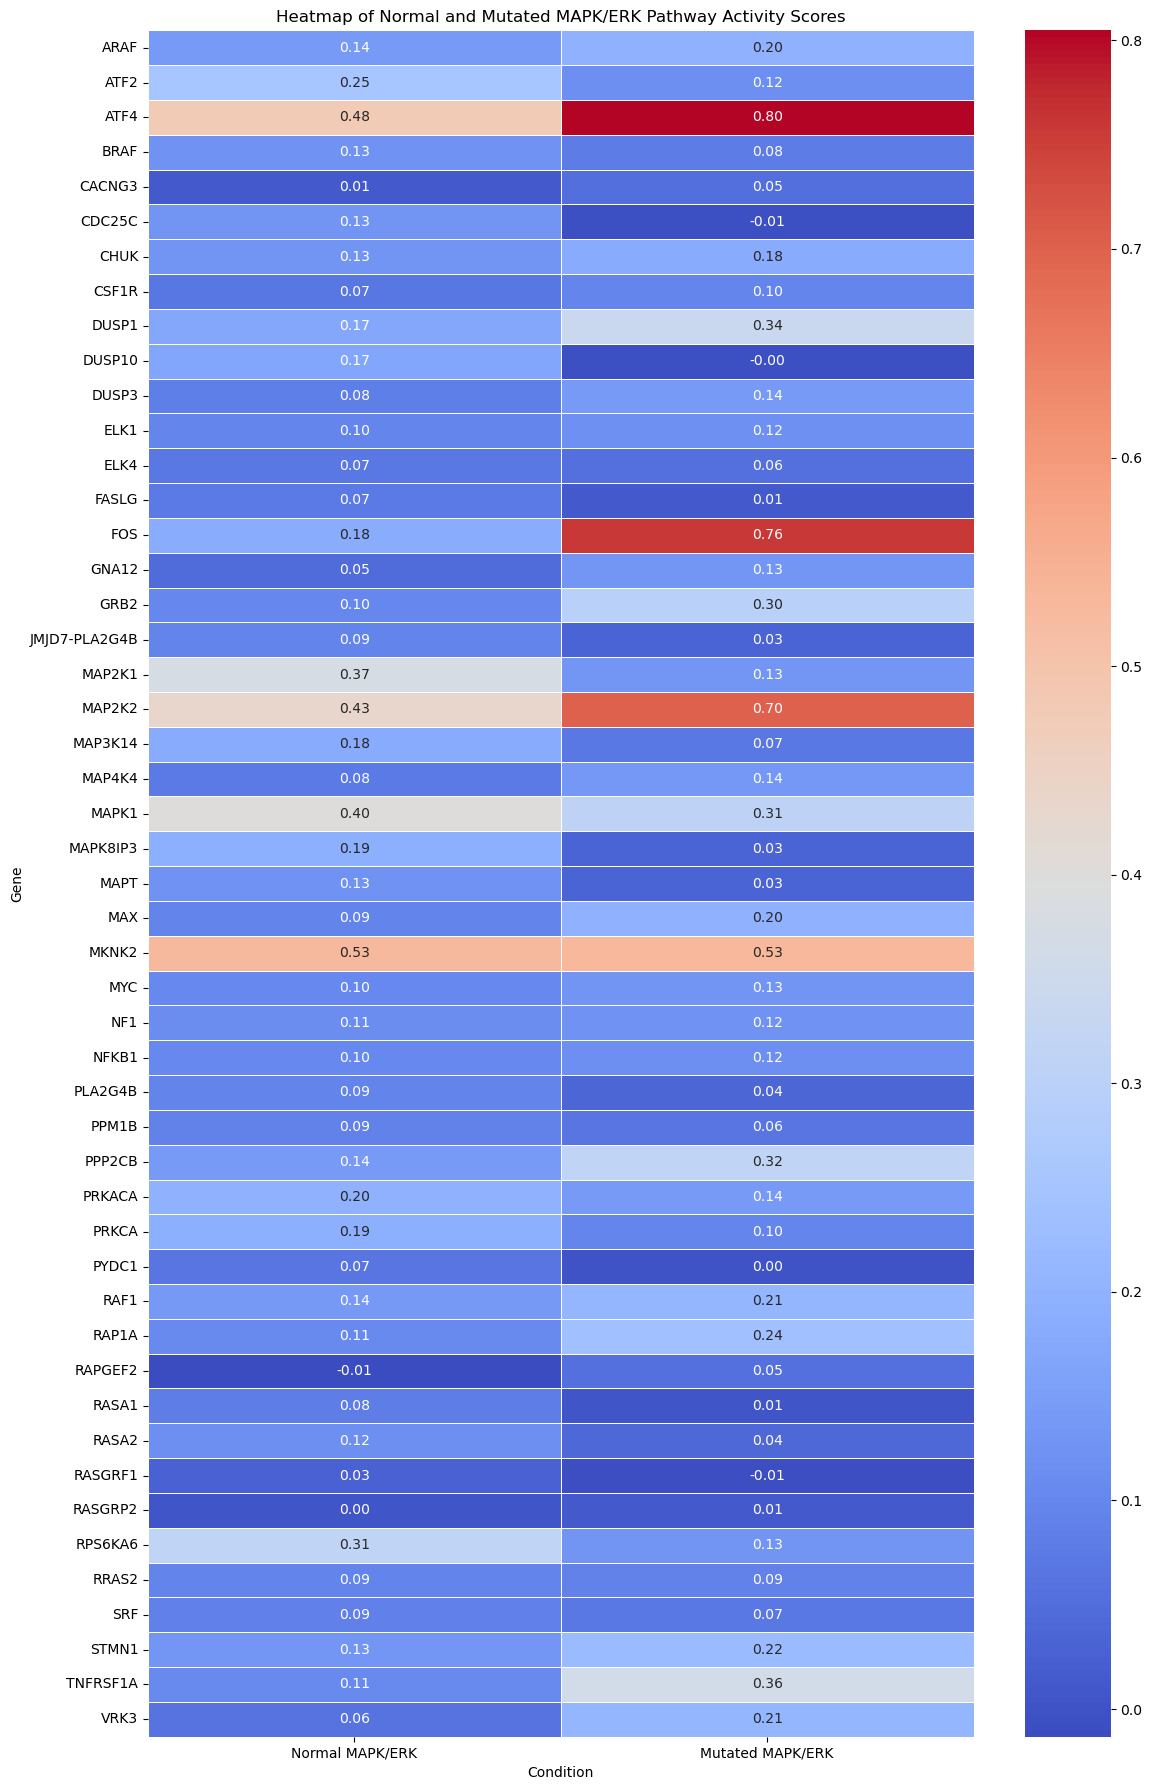

In [281]:
#Normal and Mutated MAPK Scores
normal_mapk_scores = pathway_activity_scores_df[
    pathway_activity_scores_df['Gene'].isin(mapk_genes)
].set_index("Gene")["Predicted Expression"]

mutated_mapk_scores = mutation_activity_scores_df[
    mutation_activity_scores_df['Gene'].isin(mapk_genes)
].set_index("Gene")["Mutation Activity Score"]

mapk_scores = pd.DataFrame({
    "Normal MAPK/ERK": normal_mapk_scores,
    "Mutated MAPK/ERK": mutated_mapk_scores
}).reset_index()

#Heatmap
heatmap_data = mapk_scores.set_index("Gene")

plt.figure(figsize=(12, 18))
sns.heatmap(
    heatmap_data, 
    cmap="coolwarm", 
    annot=True, 
    fmt=".2f", 
    cbar=True, 
    linewidths=0.5
)
plt.title("Heatmap of Normal and Mutated MAPK/ERK Pathway Activity Scores")
plt.xlabel("Condition")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()


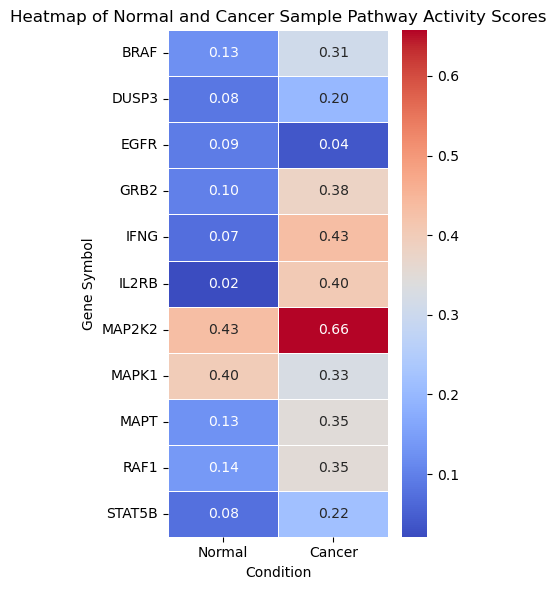

In [282]:
short_gene_list = [
    
"RAF1", "DUSP3", "MAP2K2", "MAPK1", "BRAF", "GRB2", "MAPT", "IL2RB", "EGFR", "STAT5B", "IFNG" ]

#Normal and Cancer Scores
normal_scores = pathway_activity_scores_df[
    pathway_activity_scores_df['Gene'].isin(short_gene_list)
].set_index("Gene")["Predicted Expression"]

cancer_scores = cancer_activity_scores_df[
    cancer_activity_scores_df['Gene'].isin(short_gene_list)
].set_index("Gene")["Activity_Score"]

all_genes_scores = pd.DataFrame({
    "Normal": normal_scores,
    "Cancer": cancer_scores
})

#Heatmap
plt.figure(figsize=(4, 6))
sns.heatmap(
    all_genes_scores,
    cmap="coolwarm",
    annot=True, 
    fmt=".2f",
    cbar=True,
    linewidths=0.5
)
plt.title("Heatmap of Normal and Cancer Sample Pathway Activity Scores")
plt.xlabel("Condition")
plt.ylabel("Gene Symbol")
plt.tight_layout()
plt.show()


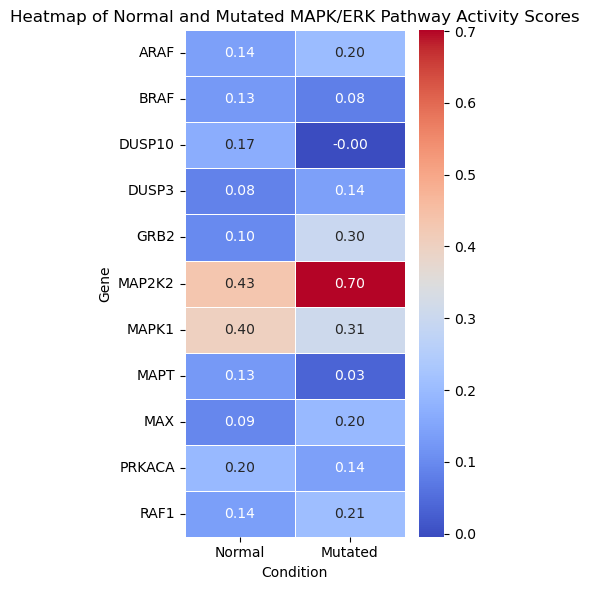

In [290]:
short_gene_list = [
    
"RAF1", "DUSP3", "MAP2K2", "MAPK1", "BRAF", "GRB2", "MAPT", "PRKACA", "ARAF", "MAX", "DUSP10" ]

normal_mapk_scores = pathway_activity_scores_df[
    pathway_activity_scores_df['Gene'].isin(short_gene_list)
].set_index("Gene")["Predicted Expression"]

mutated_mapk_scores = mutation_activity_scores_df[
    mutation_activity_scores_df['Gene'].isin(short_gene_list)
].set_index("Gene")["Mutation Activity Score"]

mapk_scores = pd.DataFrame({
    "Normal": normal_mapk_scores,
    "Mutated": mutated_mapk_scores
}).reset_index()

#Heatmap
heatmap_data = mapk_scores.set_index("Gene")

plt.figure(figsize=(4, 6))
sns.heatmap(
    heatmap_data, 
    cmap="coolwarm", 
    annot=True, 
    fmt=".2f", 
    cbar=True, 
    linewidths=0.5
)
plt.title("Heatmap of Normal and Mutated MAPK/ERK Pathway Activity Scores")
plt.xlabel("Condition")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()


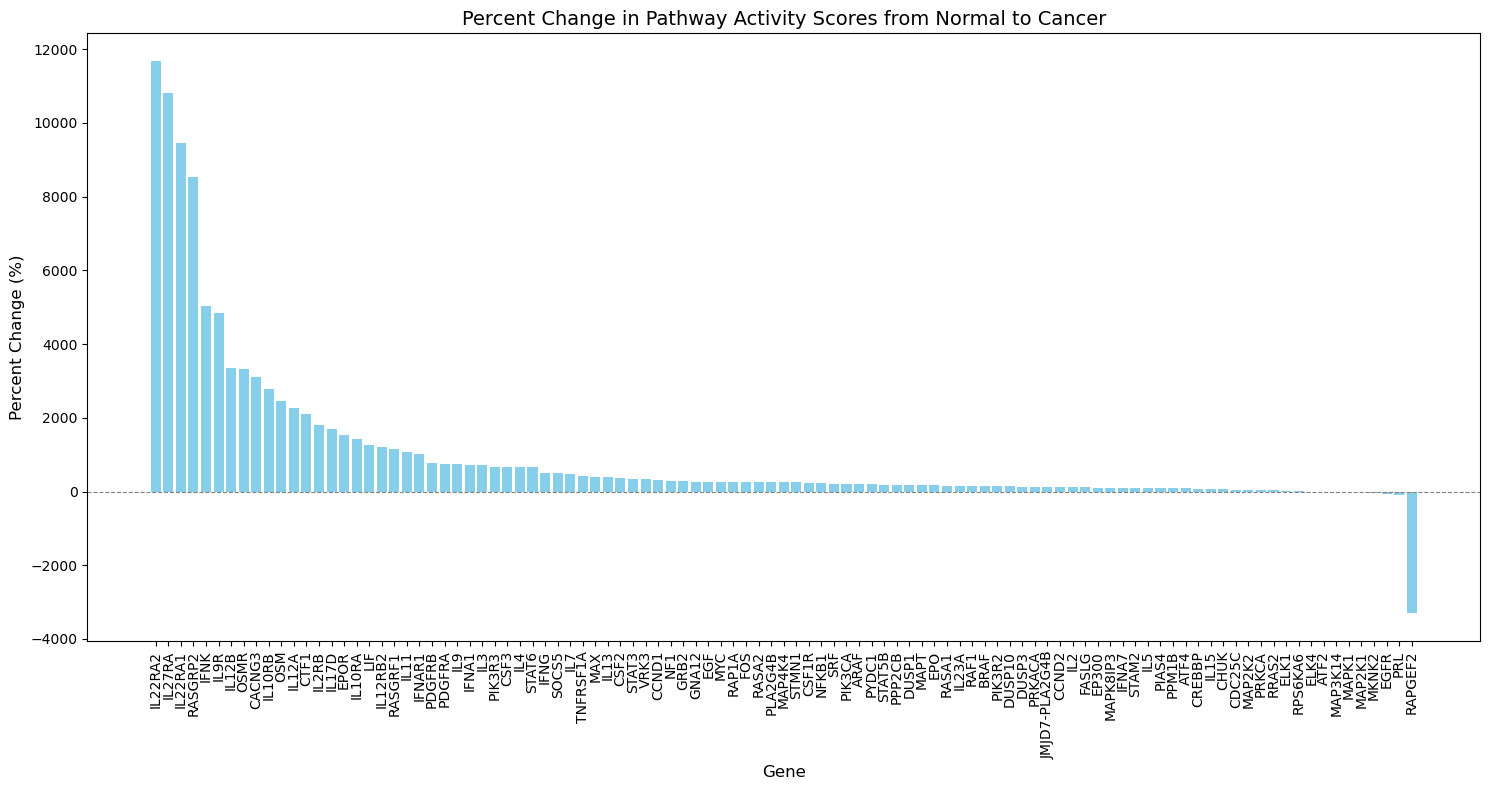

In [284]:
#Percent change
merged_data = pd.merge(
    pathway_activity_scores_df[['Gene', 'Predicted Expression']],
    cancer_activity_scores_df[['Gene', 'Activity_Score']],
    on='Gene',
    how='inner'
)

merged_data['Percent Change'] = ((merged_data['Activity_Score'] - merged_data['Predicted Expression']) /
                                 merged_data['Predicted Expression']) * 100

merged_data = merged_data.sort_values(by='Percent Change', ascending=False)

#Bar graph
plt.figure(figsize=(15, 8))
plt.bar(merged_data['Gene'], merged_data['Percent Change'], color='skyblue')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8) 
plt.xlabel('Gene', fontsize=12)
plt.ylabel('Percent Change (%)', fontsize=12)
plt.title('Percent Change in Pathway Activity Scores from Normal to Cancer', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()


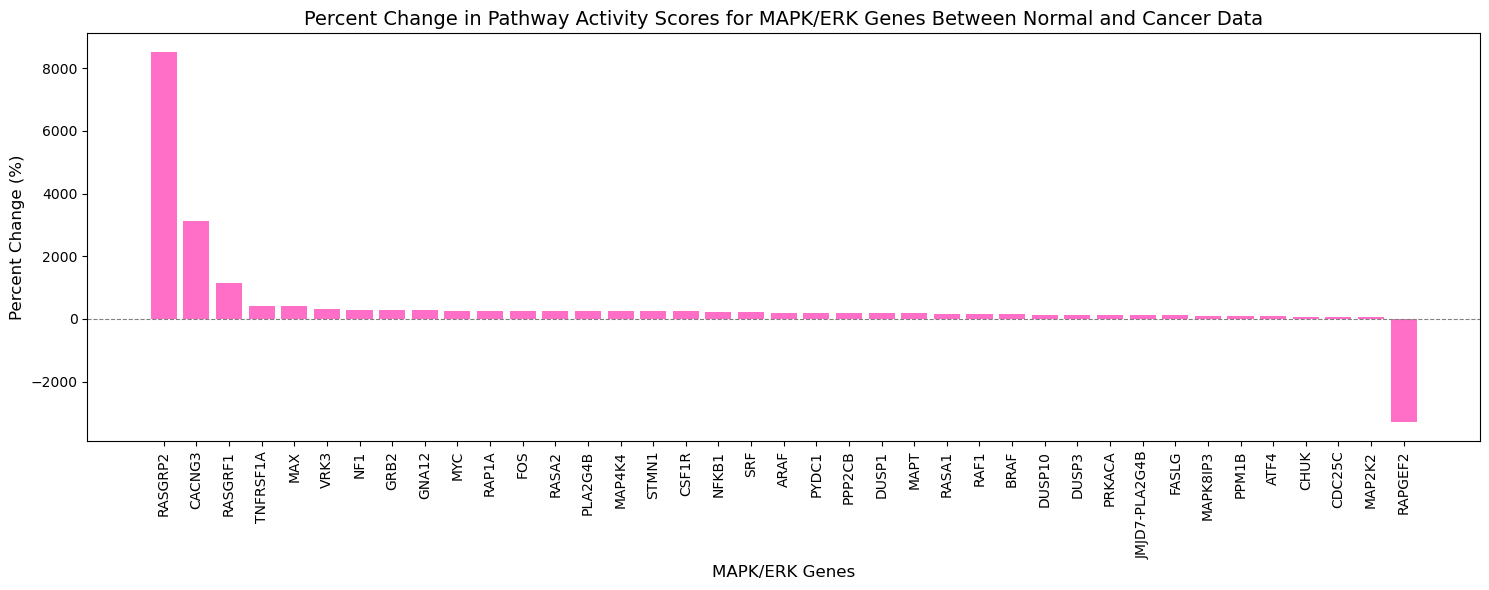

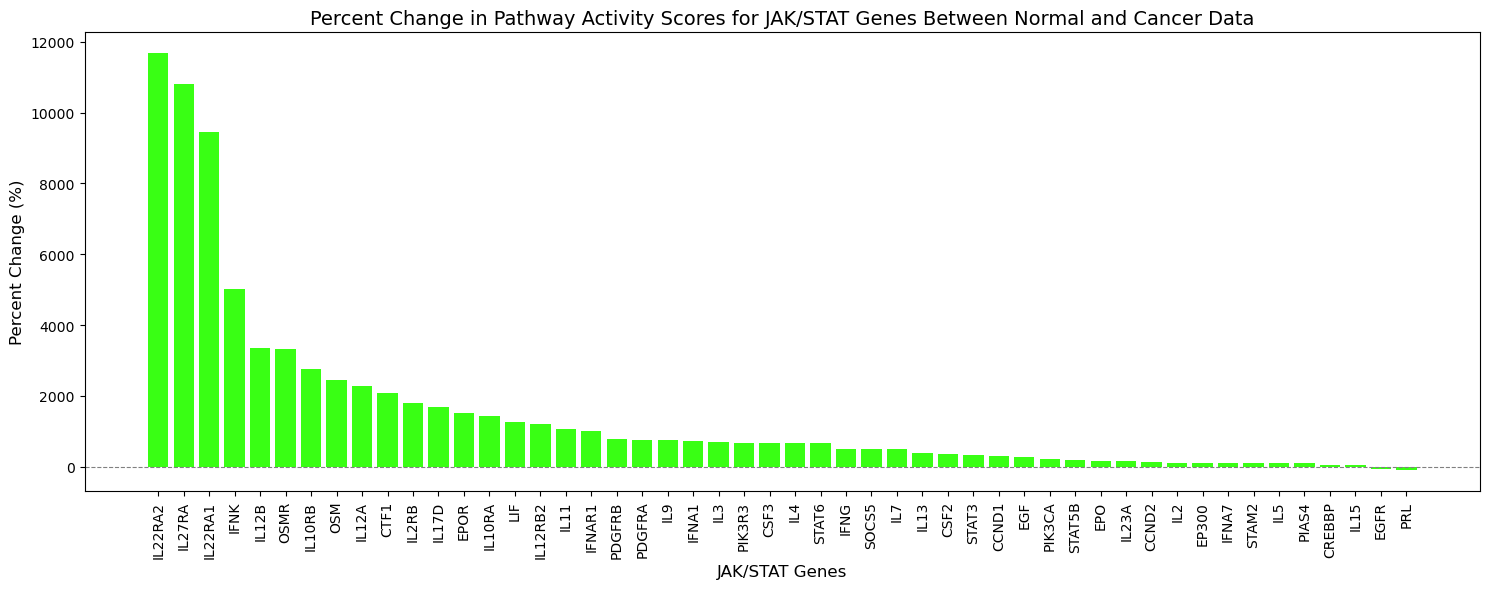

In [285]:
mapk_genes = [
    "RAF1", "PRKCA", "FASLG", "RAPGEF2", "CACNG3", "RAP1A", "RASA2", "CSF1R", "RASGRP2", "MKNK2", "STMN1",
    "DUSP3", "MAP2K2", "ARAF", "ELK1", "ELK4", "ATF2", "NFKB1", "MAP2K1", "SRF", "MAPK8IP3", "SOS1", "DUSP10", 
    "JMJD7-PLA2G4B", "PLA2G4B", "RRAS2", "RPS6KA6", "MAPT", "NF1", "GNA12", "TNFRSF1A", "PPM1B", "VRK3", 
    "BRAF", "MYC", "PYDC1", "MAPK1", "ATF4", "GRB2", "RASGRF1", "CDC25C", "DUSP1", "MAX", "PPP2CB", "RASA1", "CHUK", 
    "FOS", "MAP4K4", "MAP3K14", "PRKACA"
]

jakstat_genes = [
    "OSM", "IL2RB", "SOS2", "EPOR", "CSF3", "IL2", "CCND1", "IL10RA", "IL23A", "IFNG", "IL12B", "IL4", "IL5", "IFNA7", 
    "LIF", "EPO", "PDGFRA", "CCND2", "PDGFRB", "IL12RB2", "CREBBP", "PIK3R3", "PIAS4", "EP300", "IL27RA", "IL7", "STAM2", 
    "PIK3CA", "IL11", "STAT3", "EGF", "IFNAR1", "IL22RA1", "OSMR", "IL9", "EGFR", "IFNA1", "IFNK", "CTF1", "IL10RB", 
    "STAT5B", "IL15", "CSF2", "IL22RA2", "STAT6", "PRL", "IL17D", "IL12A", "IL13", "SOCS5", "IL3"
]


#Filter for % change
filtered_data = merged_data[(merged_data['Percent Change'] > 50) | (merged_data['Percent Change'] < -50)]

#Split data -- pathway type
mapk_data = filtered_data[filtered_data['Gene'].isin(mapk_genes)]
jakstat_data = filtered_data[filtered_data['Gene'].isin(jakstat_genes)]

mapk_data = mapk_data.sort_values(by='Percent Change', ascending=False)
jakstat_data = jakstat_data.sort_values(by='Percent Change', ascending=False)

plt.figure(figsize=(15, 6))
plt.bar(mapk_data['Gene'], mapk_data['Percent Change'], color='#FF6EC7')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8) 
plt.xlabel('MAPK/ERK Genes', fontsize=12)
plt.ylabel('Percent Change (%)', fontsize=12)
plt.title('Percent Change in Pathway Activity Scores for MAPK/ERK Genes Between Normal and Cancer Data', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
plt.bar(jakstat_data['Gene'], jakstat_data['Percent Change'], color='#39FF14')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  
plt.xlabel('JAK/STAT Genes', fontsize=12)
plt.ylabel('Percent Change (%)', fontsize=12)
plt.title('Percent Change in Pathway Activity Scores for JAK/STAT Genes Between Normal and Cancer Data', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()


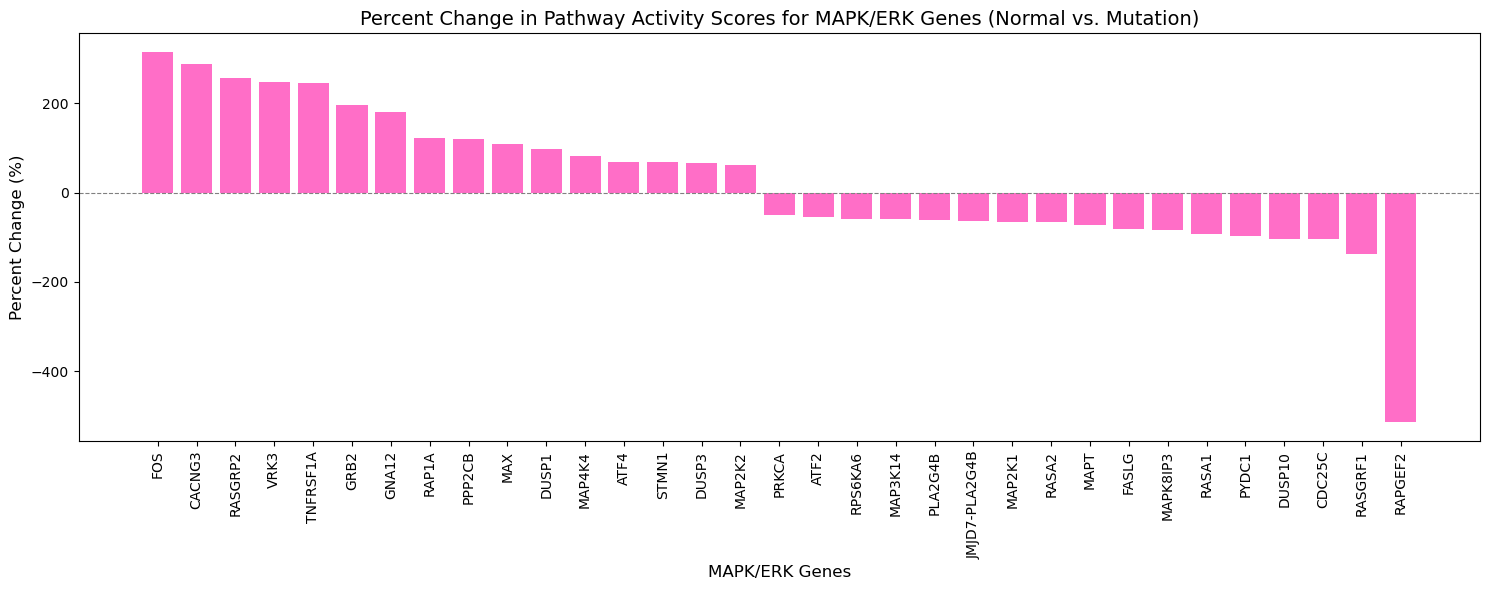

In [286]:

mapk_genes = [
    "RAF1", "PRKCA", "FASLG", "RAPGEF2", "CACNG3", "RAP1A", "RASA2", "CSF1R", "RASGRP2", "MKNK2", "STMN1",
    "DUSP3", "MAP2K2", "ARAF", "ELK1", "ELK4", "ATF2", "NFKB1", "MAP2K1", "SRF", "MAPK8IP3", "SOS1", "DUSP10", 
    "JMJD7-PLA2G4B", "PLA2G4B", "RRAS2", "RPS6KA6", "MAPT", "NF1", "GNA12", "TNFRSF1A", "PPM1B", "VRK3", 
    "BRAF", "MYC", "PYDC1", "MAPK1", "ATF4", "GRB2", "RASGRF1", "CDC25C", "DUSP1", "MAX", "PPP2CB", "RASA1", "CHUK", 
    "FOS", "MAP4K4", "MAP3K14", "PRKACA"
]



#% change normal to mutation
merged_data = pd.merge(
    pathway_activity_scores_df[['Gene', 'Predicted Expression']],
    mutation_activity_scores_df[['Gene', 'Mutation Activity Score']],
    on='Gene',
    how='inner'
)

merged_data['Percent Change'] = ((merged_data['Mutation Activity Score'] - merged_data['Predicted Expression']) /
                                 merged_data['Predicted Expression']) * 100

filtered_data = merged_data[(merged_data['Percent Change'] > 50) | (merged_data['Percent Change'] < -50)]

mapk_data = filtered_data[filtered_data['Gene'].isin(mapk_genes)]

mapk_data = mapk_data.sort_values(by='Percent Change', ascending=False)

#Plot
plt.figure(figsize=(15, 6))
plt.bar(mapk_data['Gene'], mapk_data['Percent Change'], color='#FF6EC7')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  
plt.xlabel('MAPK/ERK Genes', fontsize=12)
plt.ylabel('Percent Change (%)', fontsize=12)
plt.title('Percent Change in Pathway Activity Scores for MAPK/ERK Genes (Normal vs. Mutation)', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()



/var/folders/vw/8wh4b3l534q3sd8fkct0l0xr0000gn/T/ipykernel_59127/3382456529.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.rename(columns={


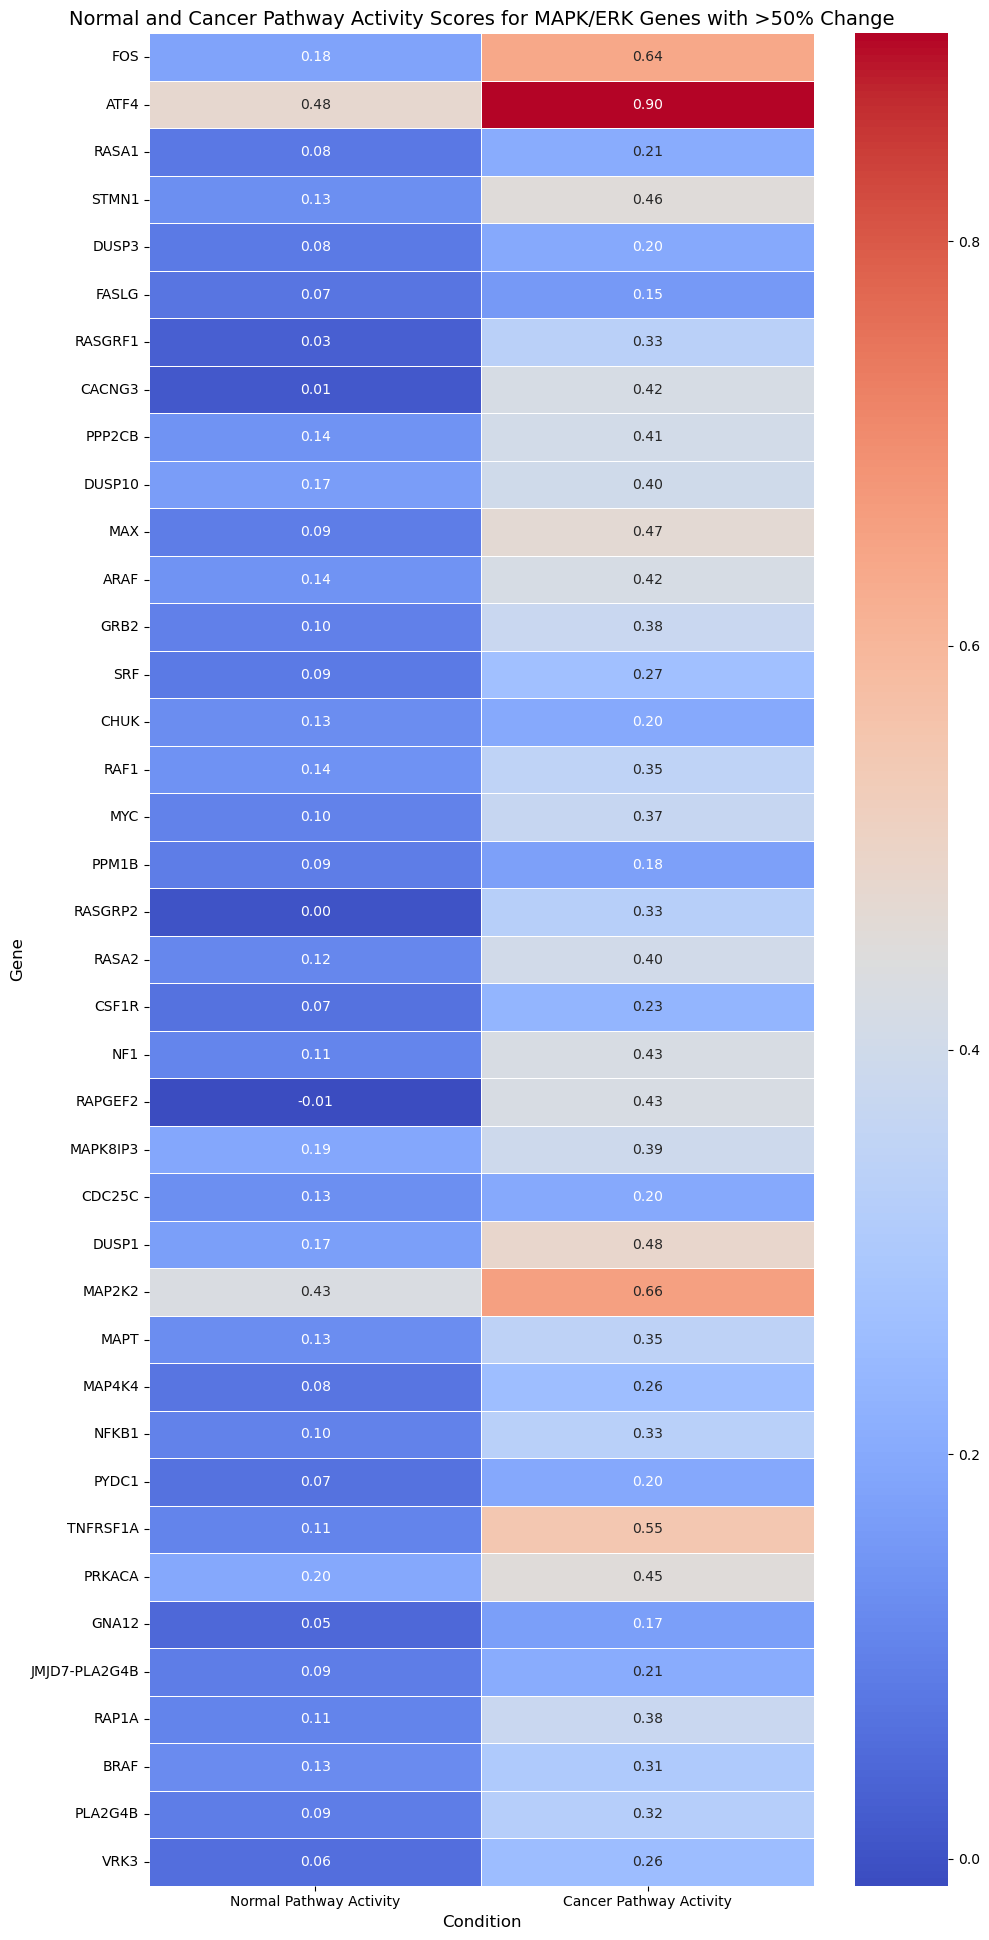

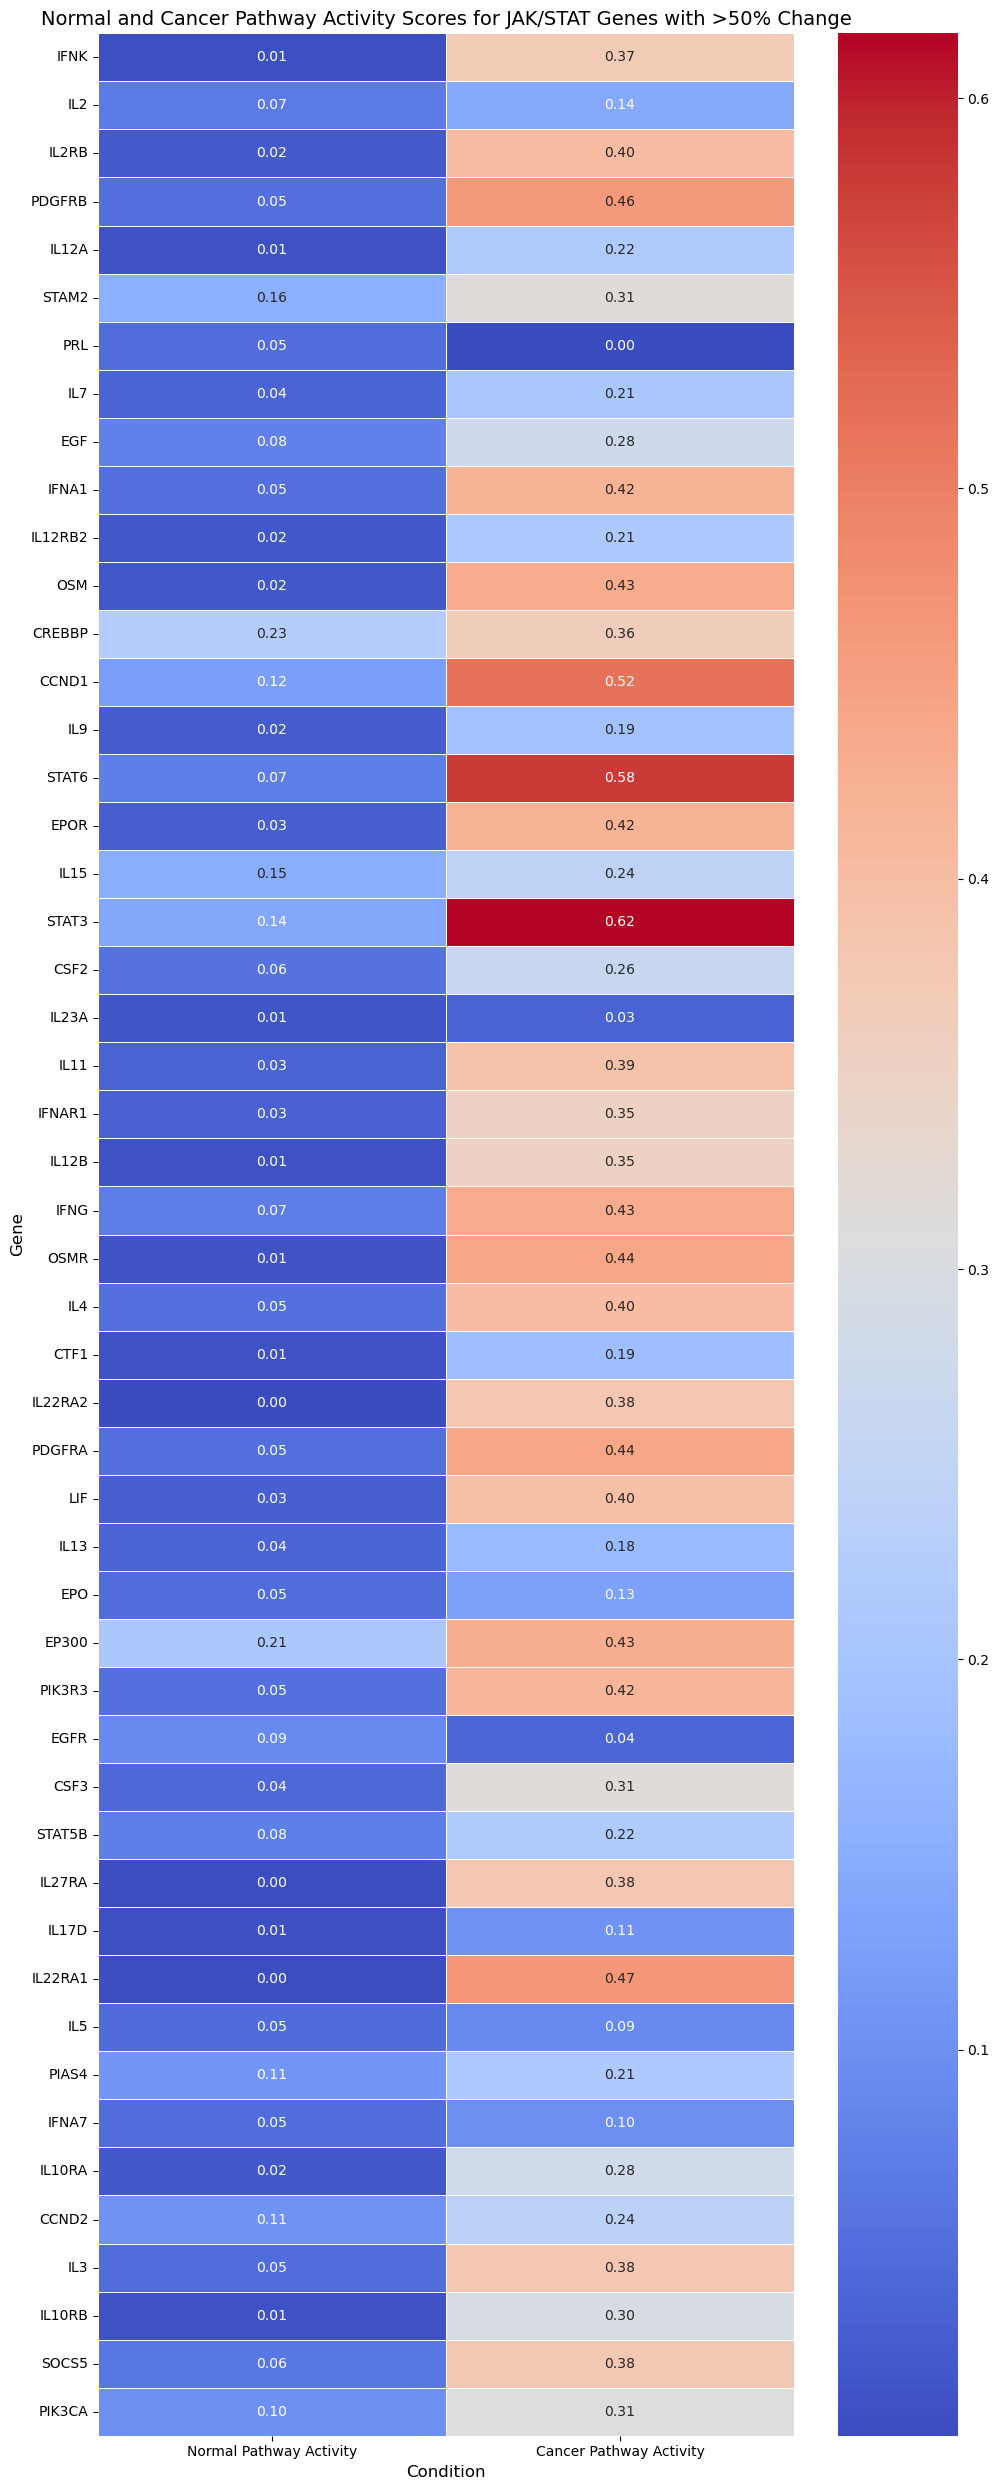

In [287]:

mapk_genes = [
    "RAF1", "PRKCA", "FASLG", "RAPGEF2", "CACNG3", "RAP1A", "RASA2", "CSF1R", "RASGRP2", "MKNK2", "STMN1",
    "DUSP3", "MAP2K2", "ARAF", "ELK1", "ELK4", "ATF2", "NFKB1", "MAP2K1", "SRF", "MAPK8IP3", "SOS1", "DUSP10", 
    "JMJD7-PLA2G4B", "PLA2G4B", "RRAS2", "RPS6KA6", "MAPT", "NF1", "GNA12", "TNFRSF1A", "PPM1B", "VRK3", 
    "BRAF", "MYC", "PYDC1", "MAPK1", "ATF4", "GRB2", "RASGRF1", "CDC25C", "DUSP1", "MAX", "PPP2CB", "RASA1", "CHUK", 
    "FOS", "MAP4K4", "MAP3K14", "PRKACA"
]
jak_stat_genes = [
    "OSM", "IL2RB", "SOS2", "EPOR", "CSF3", "IL2", "CCND1", "IL10RA", "IL23A", "IFNG", "IL12B", "IL4", "IL5", "IFNA7", 
    "LIF", "EPO", "PDGFRA", "CCND2", "PDGFRB", "IL12RB2", "CREBBP", "PIK3R3", "PIAS4", "EP300", "IL27RA", "IL7", "STAM2", 
    "PIK3CA", "IL11", "STAT3", "EGF", "IFNAR1", "IL22RA1", "OSMR", "IL9", "EGFR", "IFNA1", "IFNK", "CTF1", "IL10RB", 
    "STAT5B", "IL15", "CSF2", "IL22RA2", "STAT6", "PRL", "IL17D", "IL12A", "IL13", "SOCS5", "IL3"
]

merged_data = pd.merge(
    pathway_activity_scores_df[['Gene', 'Predicted Expression']],
    cancer_activity_scores_df[['Gene', 'Activity_Score']],
    on='Gene',
    how='inner'
)

merged_data['Percent Change'] = ((merged_data['Activity_Score'] - merged_data['Predicted Expression']) /
                                 merged_data['Predicted Expression']) * 100

filtered_data = merged_data[(merged_data['Percent Change'] > 50) | (merged_data['Percent Change'] < -50)]

filtered_data.rename(columns={
    'Predicted Expression': 'Normal Pathway Activity',
    'Activity_Score': 'Cancer Pathway Activity'
}, inplace=True)

mapk_filtered_data = filtered_data[filtered_data['Gene'].isin(mapk_genes)]
jakstat_filtered_data = filtered_data[filtered_data['Gene'].isin(jak_stat_genes)]

#heatmap
def plot_heatmap(data, title):
    heatmap_data = data.set_index('Gene')[['Normal Pathway Activity', 'Cancer Pathway Activity']]
    plt.figure(figsize=(10, len(heatmap_data) * 0.5))  
    sns.heatmap(
        heatmap_data,
        cmap="coolwarm",
        annot=True,
        fmt=".2f",
        cbar=True,
        linewidths=0.5
    )
    plt.title(title, fontsize=14)
    plt.xlabel('Condition', fontsize=12)
    plt.ylabel('Gene', fontsize=12)
    plt.tight_layout()
    plt.show()

plot_heatmap(mapk_filtered_data, 'Normal and Cancer Pathway Activity Scores for MAPK/ERK Genes with >50% Change')

plot_heatmap(jakstat_filtered_data, 'Normal and Cancer Pathway Activity Scores for JAK/STAT Genes with >50% Change')


In [288]:
!pip install shap

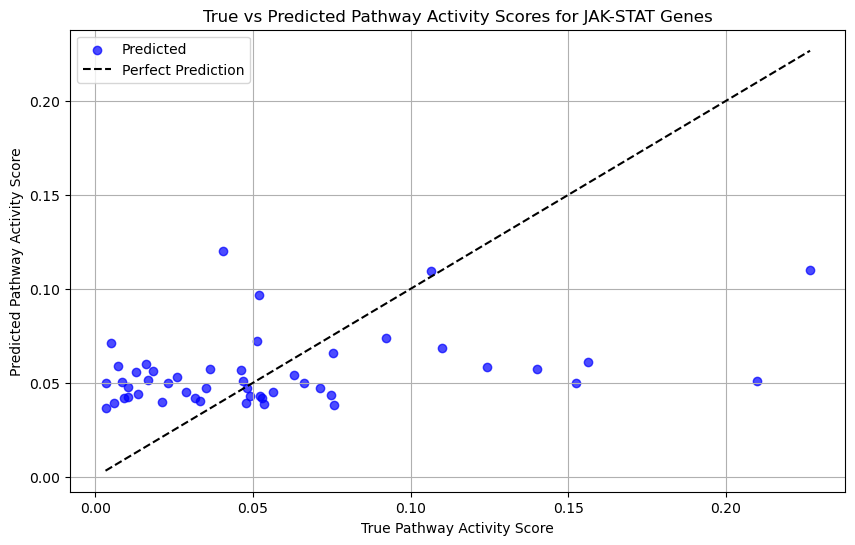

/var/folders/vw/8wh4b3l534q3sd8fkct0l0xr0000gn/T/ipykernel_59127/3616560010.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coefficients, y=features, palette="viridis")


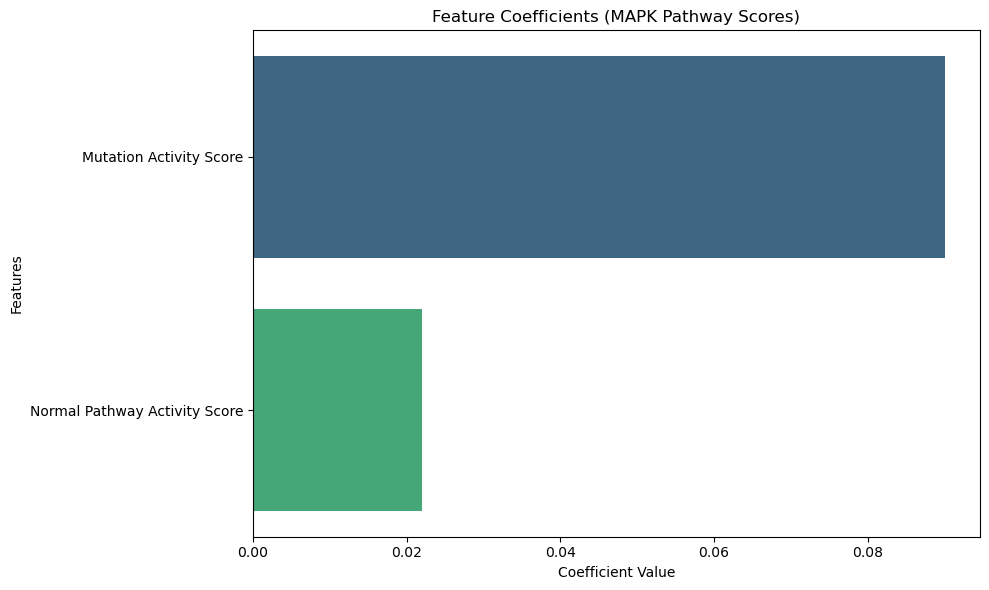

In [294]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the following DataFrames:
# mutation_activity_scores_df: ['Gene', 'Expression', 'GAT_Embedding', 'Mutation Activity Score']
# pathway_activity_scores_df: ['Gene', 'Expression', 'GAT_Embedding', 'Pathway Activity Score']

# Step 1: Filter MAPK and JAK-STAT Genes
mapk_genes_scores = mutation_activity_scores_df[
    mutation_activity_scores_df['Gene'].isin(mapk_genes)
].set_index("Gene")[["Mutation Activity Score"]]

normal_mapk_scores = pathway_activity_scores_df[
    pathway_activity_scores_df['Gene'].isin(mapk_genes)
].set_index("Gene")[["Predicted Expression"]]

jak_stat_scores = pathway_activity_scores_df[
    pathway_activity_scores_df['Gene'].isin(jak_stat_genes)
].set_index("Gene")[["Predicted Expression"]]

# Ensure sufficient samples for JAK-STAT
jak_stat_scores = jak_stat_scores.dropna()

# Step 2: Combine MAPK Mutation and Normal Scores
mapk_combined_scores = pd.concat([mapk_genes_scores, normal_mapk_scores], axis=1).dropna()
mapk_combined_scores.columns = ["Mutation Activity Score", "Normal Pathway Activity Score"]

# Prepare features (X) and target (y)
X = mapk_combined_scores.values  # Features: MAPK mutation and normal pathway scores
y = jak_stat_scores["Predicted Expression"].values  # Targets: Pathway activity scores for all JAK-STAT genes

# Ensure sufficient samples
if X.shape[0] == 0 or len(y) == 0:
    raise ValueError("MAPK features (X) or JAK-STAT pathway activity scores (y) are empty. Ensure the data is correctly prepared.")

# Step 3: Train Linear Regression Model
model = LinearRegression()
model.fit(X, y[:X.shape[0]])  # Fit the model to the available data

# Predict the pathway activity scores for all JAK-STAT genes
y_pred = model.predict(X)

# Step 4: Plot True vs Predicted Pathway Scores
plt.figure(figsize=(10, 6))
plt.scatter(y[:X.shape[0]], y_pred, alpha=0.7, color="blue", label="Predicted")
plt.plot(
    [y.min(), y.max()],
    [y.min(), y.max()],
    'k--',
    label="Perfect Prediction"
)
plt.title("True vs Predicted Pathway Activity Scores for JAK/STAT Genes")
plt.xlabel("True Pathway Activity Score")
plt.ylabel("Predicted Pathway Activity Score")
plt.legend()
plt.grid()
plt.show()

# Step 5: Coefficient Importance Plot
coefficients = model.coef_
features = ["Mutation Activity Score", "Normal Pathway Activity Score"]

plt.figure(figsize=(10, 6))
sns.barplot(x=coefficients, y=features, palette="viridis")
plt.title("Feature Coefficients (MAPK/ERK Pathway Scores)")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

MAPK/ERK Combined Features (Sample):
         Mutation Activity Score  Embedding_1  DegreeCentrality  \
RAF1                    0.207411     0.224144          0.261682   
PRKCA                   0.095602     0.156161          0.261682   
FASLG                   0.013958     0.026584          0.252336   
RAPGEF2                 0.054987     0.065477          0.028037   
CACNG3                  0.051010     0.102019          0.037383   

         ClosenessCentrality  BetweennessCentrality  
RAF1                0.575269               0.008389  
PRKCA               0.575269               0.018965  
FASLG               0.543147               0.000695  
RAPGEF2             0.380783               0.000012  
CACNG3              0.386282               0.000313  
JAK/STAT Targets:
       Predicted Expression
count             50.000000
mean               0.056360
std                0.051643
min                0.003217
25%                0.017173
50%                0.047313
75%                0.0

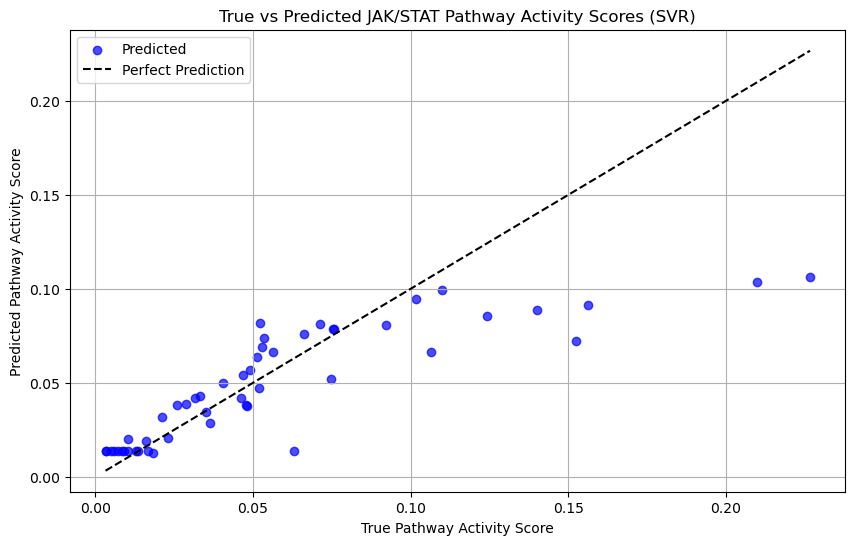

  0%|          | 0/50 [00:00<?, ?it/s]

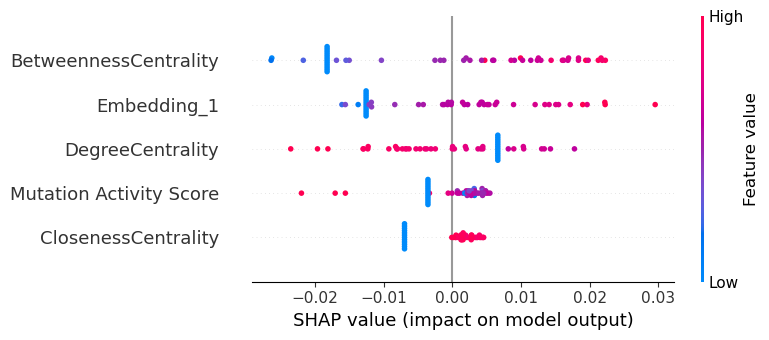

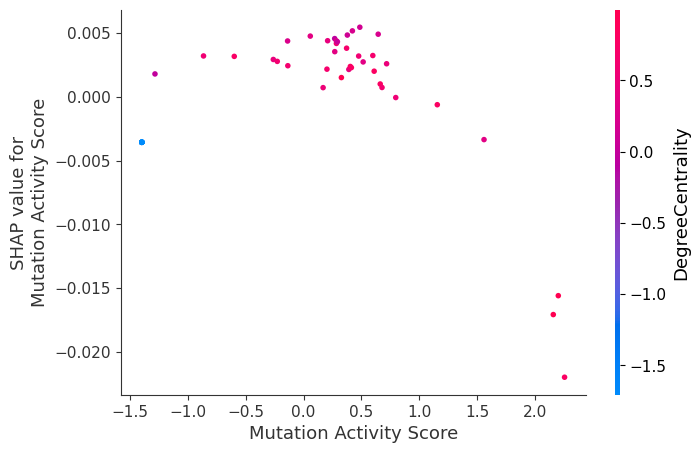

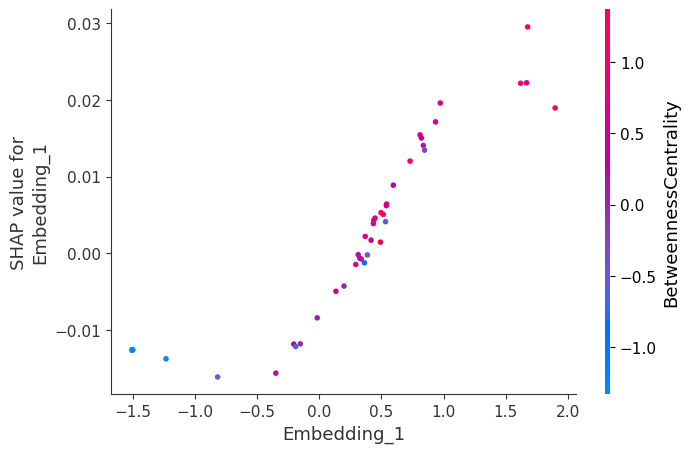

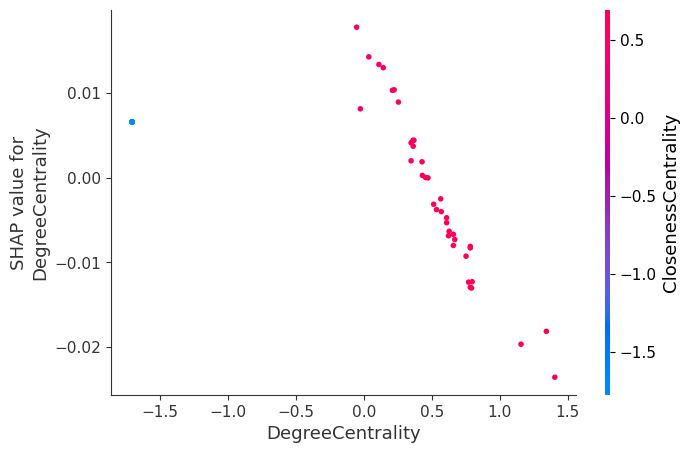

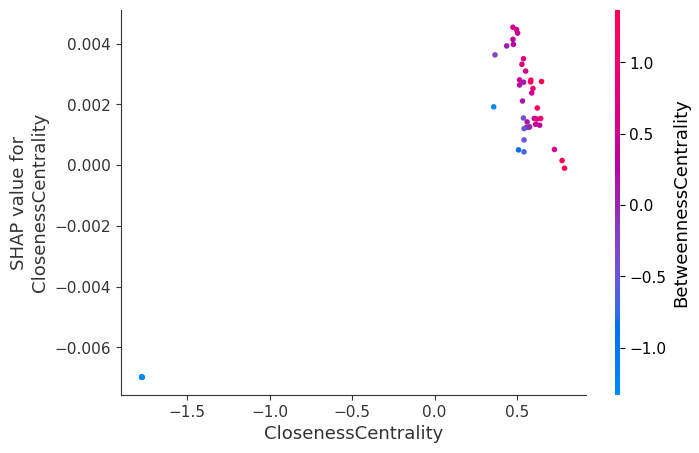

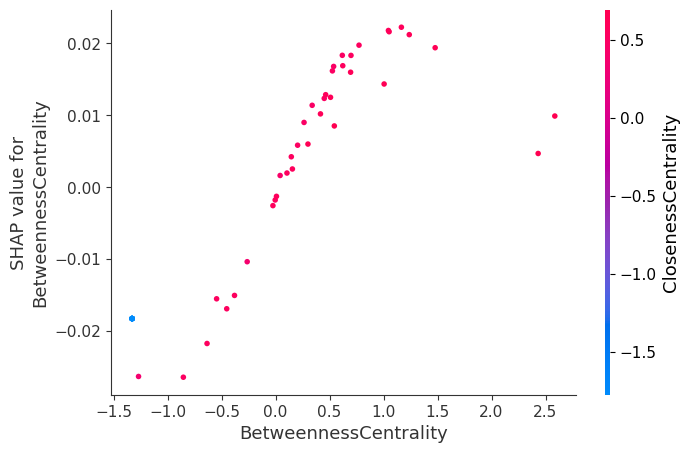

Predictions saved to svr_predictions.csv
SHAP values saved to svr_shap_values.csv
Index(['MAPK/ERK Gene', 'True Pathway Activity Score', 'JAK/STAT Gene',
       'Predicted Pathway Activity Score'],
      dtype='object')


In [289]:
#Network graph
edges = [tuple(x) for x in pathway_data[['node1', 'node2', 'combined_edge_weight']].values]

G = nx.Graph()
G.add_weighted_edges_from(edges)

#graph-based features
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

network_graph_df = pd.DataFrame({
    'Node': list(G.nodes),
    'DegreeCentrality': [degree_centrality[node] for node in G.nodes],
    'ClosenessCentrality': [closeness_centrality[node] for node in G.nodes],
    'BetweennessCentrality': [betweenness_centrality[node] for node in G.nodes]
})

#Mapk scores, GAT Embeddings, and network features
mapk_genes_scores = mutation_activity_scores_df[
    mutation_activity_scores_df['Gene'].isin(mapk_genes)
].set_index("Gene")[["Mutation Activity Score"]]

mapk_embedding_features = mutation_activity_scores_df[
    mutation_activity_scores_df['Gene'].isin(mapk_genes)
].set_index("Gene")[["GAT_Embedding"]]

def split_embedding(value):
    try:
        if isinstance(value, str):
            return pd.Series(map(float, value.split()))
        else:
            return pd.Series([value])
    except (ValueError, TypeError):
        return pd.Series([0.0])

mapk_embedding_features = mapk_embedding_features["GAT_Embedding"].apply(split_embedding)
embedding_columns = [f"Embedding_{i+1}" for i in range(mapk_embedding_features.shape[1])]
mapk_embedding_features.columns = embedding_columns

#Map graph features to Mapk genes
mapk_graph_features = network_graph_df[network_graph_df['Node'].isin(mapk_genes)].set_index('Node')
mapk_combined_features = pd.concat(
    [
        mapk_genes_scores,
        mapk_embedding_features,
        mapk_graph_features
    ],
    axis=1
).fillna(0)

print("MAPK/ERK Combined Features (Sample):")
print(mapk_combined_features.head())

#jak stat targets
jak_stat_targets = pathway_activity_scores_df[
    pathway_activity_scores_df['Gene'].isin(jak_stat_genes)
].set_index("Gene")[["Predicted Expression"]]

print("JAK/STAT Targets:")
print(jak_stat_targets.describe())

#find mapk jakstat connections
relevant_features = []
jak_stat_genes_list = []
mapk_genes_list = []
for jak_gene in jak_stat_targets.index:
    connected_mapk_genes = [
        node for node in nx.neighbors(G, jak_gene) if node in mapk_combined_features.index
    ]
    if connected_mapk_genes:
        relevant_features.append(mapk_combined_features.loc[connected_mapk_genes].mean(axis=0))
        mapk_genes_list.append(connected_mapk_genes[0])
    else:
        relevant_features.append(pd.Series(0, index=mapk_combined_features.columns))
        mapk_genes_list.append(np.nan)
    jak_stat_genes_list.append(jak_gene)

X = pd.DataFrame(relevant_features).values
y = jak_stat_targets["Predicted Expression"].values

print(f"Shape of X (MAPK features): {X.shape}")
print(f"Shape of y (JAK-STAT targets): {y.shape}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


#SVR
param_grid = {
    'C': [0.1, 1, 10, 100],       
    'epsilon': [0.01, 0.1, 1],    
    'gamma': ['scale', 'auto'],   
    'kernel': ['rbf'],            
}

svr = SVR()
grid_search = GridSearchCV(
    estimator=svr,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_scaled, y)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

#Predict JAK/STAT scores
y_pred = best_model.predict(X_scaled)

#Evaluation metrics
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.7, color="blue", label="Predicted")
plt.plot(
    [y.min(), y.max()],
    [y.min(), y.max()],
    'k--',
    label="Perfect Prediction"
)
plt.title("True vs Predicted JAK/STAT Pathway Activity Scores (SVR)")
plt.xlabel("True Pathway Activity Score")
plt.ylabel("Predicted Pathway Activity Score")
plt.legend()
plt.grid()
plt.show()

feature_names = mapk_combined_features.columns.tolist()

#SHAP -- feature importance
explainer = shap.KernelExplainer(best_model.predict, X_scaled)
shap_values = explainer.shap_values(X_scaled)
shap.summary_plot(shap_values, X_scaled, feature_names=feature_names)
for i, feature in enumerate(feature_names):
    shap.dependence_plot(i, shap_values, X_scaled, feature_names=feature_names)


mapk_genes_list = mapk_genes_list[:len(y_pred)]
jak_stat_genes_list = jak_stat_genes_list[:len(y_pred)]


svr_df = pd.DataFrame({
    "MAPK/ERK Gene": mapk_genes_list,
    "True Pathway Activity Score": y,
    "JAK/STAT Gene": jak_stat_genes_list,
    "Predicted Pathway Activity Score": y_pred
})

svr_df.to_csv('/Users/teja/Documents/svr_predictions.csv', index=False)
print("Predictions saved to svr_predictions.csv")

shap_values_df = pd.DataFrame(shap_values, columns=feature_names)
shap_values_df.to_csv('svr_shap_values.csv', index=False)
print("SHAP values saved to svr_shap_values.csv")
print(svr_df.columns)

svr_df = pd.read_csv('/Users/teja/Documents/svr_predictions.csv')
